<a href="https://colab.research.google.com/github/MEGlantz/2022-Ukraine-Russia-War-Dataset/blob/main/RussianPresidentsWordsEDAversion2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings

# Filter out the specific deprecation warning
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
pip install nltk

In [4]:
pip install pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 32.9 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import pickle
import pyLDAvis.lda_model
from collections import Counter
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', 100)

/usr/local/lib/python3.10/dist-packages/textblob/_text.py:218: DeprecationWarning: invalid escape sequence '\.'
  RE_ABBR1 = re.compile("^[A-Za-z]\.$")       # single letter, "T. De Smedt"
/usr/local/lib/python3.10/dist-packages/textblob/_text.py:219: DeprecationWarning: invalid escape sequence '\.'
  RE_ABBR2 = re.compile("^([A-Za-z]\.)+$")    # alternating letters, "U.S."


In [6]:
# load data
df = pd.read_csv('/content/drive/MyDrive/Kremlin Transcripts August 2023/preprocessed_text_8312023.csv')
df.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Unnamed: 0                 date persons                         place  \
0           0  1999-12-31T00:01:00      []           The Kremlin, Moscow   
1           1  1999-12-31T00:02:00      []           The Kremlin, Moscow   
2           2  1999-12-31T00:03:00      []           The Kremlin, Moscow   
3           3  2000-01-04T00:00:00      []                        Moscow   
4           4  2000-01-11T00:00:00      []  State Kremlin Palace, Moscow   
5           5  2000-01-15T00:00:00      []                           NaN   
6           6  2000-01-18T00:00:00      []                        Moscow   
7           7  2000-01-18T00:00:00      []                        Moscow   
8           8  2000-01-21T00:00:00      []                        Moscow   
9           9  2000-01-23T00:00:00      []                           NaN   

                                                                                             title  \
0                                              New Year Address by Acting President Vladimir Putin   
1                                   Address at an expanded meeting of the Russian Security Council   
2                                                                       Statement by Boris Yeltsin   
3                                                                Interview with the ORT TV Channel   
4                          Speech at gala function marking the second millennium of Christ’s birth   
5                                                                       Interview with ORT Channel   
6  Conversation with the press during a break in the first plenary meeting of the Third State Duma   
7                                      A speech at the first plenary meeting of the 3rd State Duma   
8                            Opening remarks at a meeting of the Russian Interior Ministry’s Board   
9                                                                Interview with the RTR TV Channel   

  langs  \
0    en   
1    en   
2    en   
3    en   
4    en   
5    en   
6    en   
7    en   
8    en   
9    en   

                                                                        transcripts_sentence_tokenized  \
0  ['Vladimir Putin: Dear friends, On New Year’s Eve, my family and I planned to gather round the T...   
1  ['Vladimir Putin: Good afternoon, distinguished colleagues.', 'This will be a short meeting.', '...   
2  ['Boris Yeltsin: Dear Russians, In a few hours we will see a magical date on our calendars, the ...   
3  ['Question: Mr Putin, the sudden resignation of Mr Yeltsin has prompted many questions in this c...   
4  ['Vladimir Putin: Dear friends, We are again gathered here today, this time on the occasion of t...   
5  ['Sergei Dorenko: Mr. Putin, how do you like your new office, new chair, and your new position?'...   
6  ['Question: You have said you were not indifferent to who would be State Duma Speaker.', 'Now, y...   
7  ['Vladimir Putin: I am happy to see you in the congress hall of the State Duma.', 'I would like ...   
8  ['Vladimir Putin: Distinguished colleagues, We last gathered together for a meeting of the Inter...   
9  ['Nikolai Svanidze: The most burning topic today is the situation in the State Duma.', 'We have ...   

                                                                                     stopwords_removed  \
0  ['vladimir', 'putin', 'dear', 'friends', 'new', 'year', '’', 'eve', 'family', 'planned', 'gather...   
1  ['vladimir', 'putin', 'good', 'afternoon', 'distinguished', 'colleagues', 'short', 'meeting', 'a...   
2  ['boris', 'yeltsin', 'dear', 'russians', 'hours', 'see', 'magical', 'date', 'calendars', 'year',...   
3  ['question', 'mr', 'putin', 'sudden', 'resignation', 'mr', 'yeltsin', 'prompted', 'many', 'quest...   
4  ['vladimir', 'putin', 'dear', 'friends', 'gathered', 'today', 'time', 'occasion', 'joyful', 'cel...   
5  ['sergei', 'dorenko', 'mr.', 'putin', 'like', 'new', 'office', 'new', 'chair', 'new', 'position'...   
6  ['questio

In [7]:
# convert date field to date/time object
df['date'] = pd.to_datetime(df['date'])
df.head(10)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Unnamed: 0                date persons                         place  \
0           0 1999-12-31 00:01:00      []           The Kremlin, Moscow   
1           1 1999-12-31 00:02:00      []           The Kremlin, Moscow   
2           2 1999-12-31 00:03:00      []           The Kremlin, Moscow   
3           3 2000-01-04 00:00:00      []                        Moscow   
4           4 2000-01-11 00:00:00      []  State Kremlin Palace, Moscow   
5           5 2000-01-15 00:00:00      []                           NaN   
6           6 2000-01-18 00:00:00      []                        Moscow   
7           7 2000-01-18 00:00:00      []                        Moscow   
8           8 2000-01-21 00:00:00      []                        Moscow   
9           9 2000-01-23 00:00:00      []                           NaN   

                                                                                             title  \
0                                              New Year Address by Acting President Vladimir Putin   
1                                   Address at an expanded meeting of the Russian Security Council   
2                                                                       Statement by Boris Yeltsin   
3                                                                Interview with the ORT TV Channel   
4                          Speech at gala function marking the second millennium of Christ’s birth   
5                                                                       Interview with ORT Channel   
6  Conversation with the press during a break in the first plenary meeting of the Third State Duma   
7                                      A speech at the first plenary meeting of the 3rd State Duma   
8                            Opening remarks at a meeting of the Russian Interior Ministry’s Board   
9                                                                Interview with the RTR TV Channel   

  langs  \
0    en   
1    en   
2    en   
3    en   
4    en   
5    en   
6    en   
7    en   
8    en   
9    en   

                                                                        transcripts_sentence_tokenized  \
0  ['Vladimir Putin: Dear friends, On New Year’s Eve, my family and I planned to gather round the T...   
1  ['Vladimir Putin: Good afternoon, distinguished colleagues.', 'This will be a short meeting.', '...   
2  ['Boris Yeltsin: Dear Russians, In a few hours we will see a magical date on our calendars, the ...   
3  ['Question: Mr Putin, the sudden resignation of Mr Yeltsin has prompted many questions in this c...   
4  ['Vladimir Putin: Dear friends, We are again gathered here today, this time on the occasion of t...   
5  ['Sergei Dorenko: Mr. Putin, how do you like your new office, new chair, and your new position?'...   
6  ['Question: You have said you were not indifferent to who would be State Duma Speaker.', 'Now, y...   
7  ['Vladimir Putin: I am happy to see you in the congress hall of the State Duma.', 'I would like ...   
8  ['Vladimir Putin: Distinguished colleagues, We last gathered together for a meeting of the Inter...   
9  ['Nikolai Svanidze: The most burning topic today is the situation in the State Duma.', 'We have ...   

                                                                                     stopwords_removed  \
0  ['vladimir', 'putin', 'dear', 'friends', 'new', 'year', '’', 'eve', 'family', 'planned', 'gather...   
1  ['vladimir', 'putin', 'good', 'afternoon', 'distinguished', 'colleagues', 'short', 'meeting', 'a...   
2  ['boris', 'yeltsin', 'dear', 'russians', 'hours', 'see', 'magical', 'date', 'calendars', 'year',...   
3  ['question', 'mr', 'putin', 'sudden', 'resignation', 'mr', 'yeltsin', 'prompted', 'many', 'quest...   
4  ['vladimir', 'putin', 'dear', 'friends', 'gathered', 'today', 'time', 'occasion', 'joyful', 'cel...   
5  ['sergei', 'dorenko', 'mr.', 'putin', 'like', 'new', 'office', 'new', 'chair', 'new', 'position'...   
6  ['question', 'said',

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9623 entries, 0 to 9622
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Unnamed: 0                      9623 non-null   int64         
 1   date                            9623 non-null   datetime64[ns]
 2   persons                         9623 non-null   object        
 3   place                           8975 non-null   object        
 4   title                           9623 non-null   object        
 5   langs                           9623 non-null   object        
 6   transcripts_sentence_tokenized  9623 non-null   object        
 7   stopwords_removed               9623 non-null   object        
 8   pos_tags                        9623 non-null   object        
 9   wordnet_pos                     9623 non-null   object        
 10  lemmatized                      9623 non-null   object        
dtypes: d

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Create and Explore Summary Statistics for Each Transcript

In [9]:
length = len(df['transcript_unfiltered'][3000])
print(f'Length of a sample transcript: {length}')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


KeyError: 'transcript_unfiltered'

In [ ]:
# length of unfiltered transcript

df['Transcript_Length'] = df['transcript_unfiltered'].str.len()
df.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Unnamed: 0                date  \
0           0 1999-12-31 00:01:00   
1           1 1999-12-31 00:02:00   
2           2 1999-12-31 00:03:00   
3           3 2000-01-04 00:00:00   
4           4 2000-01-11 00:00:00   
5           5 2000-01-15 00:00:00   
6           6 2000-01-18 00:00:00   
7           7 2000-01-18 00:00:00   
8           8 2000-01-21 00:00:00   
9           9 2000-01-23 00:00:00   

                                                                                 transcript_unfiltered  \
0  Vladimir Putin: Dear friends, On New Year’s Eve, my family and I planned to gather round the TV,...   
1  Vladimir Putin: Good afternoon, distinguished colleagues. This will be a short meeting. I am ask...   
2  Boris Yeltsin: Dear Russians, In a few hours we will see a magical date on our calendars, the ye...   
3  Question: Mr Putin, the sudden resignation of Mr Yeltsin has prompted many questions in this cou...   
4  Vladimir Putin: Dear friends, We are again gathered here today, this time on the occasion of the...   
5  Sergei Dorenko: Mr. Putin, how do you like your new office, new chair, and your new position? Ar...   
6  Question: You have said you were not indifferent to who would be State Duma Speaker. Now, you ar...   
7  Vladimir Putin: I am happy to see you in the congress hall of the State Duma. I would like to co...   
8  Vladimir Putin: Distinguished colleagues,  We last gathered together for a meeting of the Interi...   
9  Nikolai Svanidze: The most burning topic today is the situation in the State Duma. We have alrea...   

                          place  \
0           The Kremlin, Moscow   
1           The Kremlin, Moscow   
2           The Kremlin, Moscow   
3                        Moscow   
4  State Kremlin Palace, Moscow   
5                           NaN   
6                        Moscow   
7                        Moscow   
8                        Moscow   
9                           NaN   

                                                                                             title  \
0                                              New Year Address by Acting President Vladimir Putin   
1                                   Address at an expanded meeting of the Russian Security Council   
2                                                                       Statement by Boris Yeltsin   
3                                                                Interview with the ORT TV Channel   
4                          Speech at gala function marking the second millennium of Christ’s birth   
5                                                                       Interview with ORT Channel   
6  Conversation with the press during a break in the first plenary meeting of the Third State Duma   
7                                      A speech at the first plenary meeting of the 3rd State Duma   
8                            Opening remarks at a meeting of the Russian Interior Ministry’s Board   
9                                                                Interview with the RTR TV Channel   

                                                                                           no_contract  \
0  ['Vladimir', 'Putin:', 'Dear', 'friends,', 'On', 'New', 'Year’s', 'Eve,', 'my', 'family', 'and',...   
1  ['Vladimir', 'Putin:', 'Good', 'afternoon,', 'distinguished', 'colleagues.', 'This', 'will', 'be...   
2  ['Boris', 'Yeltsin:', 'Dear', 'Russians,', 'In', 'a', 'few', 'hours', 'we', 'will', 'see', 'a', ...   
3  ['Question:', 'Mr', 'Putin,', 'the', 'sudden', 'resignation', 'of', 'Mr', 'Yeltsin', 'has', 'pro...   
4  ['Vladimir', 'Putin:', 'Dear', 'friends,', 'We', 'are', 'again', 'gathered', 'here', 'today,', '...   
5  ['Sergei', 'Dorenko:', 'Mr.', 'Putin,', 'how', 'do', 'you', 'like', 'your', 'new', 'office,', 'n...   
6  ['Question:', 'You', 'have', 'said', 'you', 'were', 'not', 'indifferent', 'to', 'who', 'would', ...   
7  ['Vladimir', 'Putin:', 'I', 'am', 'happy', 'to', 'see', 'you', 'in',

In [ ]:
# count of words per unfiltered transcript
# cast as string to avoid problem with null value entries
df['transcript_unfiltered'] = df['transcript_unfiltered'].astype(str)

df['word_count'] = df['transcript_unfiltered'].map(lambda rev: len(rev.split()))
df.head(10)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Unnamed: 0                date  \
0           0 1999-12-31 00:01:00   
1           1 1999-12-31 00:02:00   
2           2 1999-12-31 00:03:00   
3           3 2000-01-04 00:00:00   
4           4 2000-01-11 00:00:00   
5           5 2000-01-15 00:00:00   
6           6 2000-01-18 00:00:00   
7           7 2000-01-18 00:00:00   
8           8 2000-01-21 00:00:00   
9           9 2000-01-23 00:00:00   

                                                                                 transcript_unfiltered  \
0  Vladimir Putin: Dear friends, On New Year’s Eve, my family and I planned to gather round the TV,...   
1  Vladimir Putin: Good afternoon, distinguished colleagues. This will be a short meeting. I am ask...   
2  Boris Yeltsin: Dear Russians, In a few hours we will see a magical date on our calendars, the ye...   
3  Question: Mr Putin, the sudden resignation of Mr Yeltsin has prompted many questions in this cou...   
4  Vladimir Putin: Dear friends, We are again gathered here today, this time on the occasion of the...   
5  Sergei Dorenko: Mr. Putin, how do you like your new office, new chair, and your new position? Ar...   
6  Question: You have said you were not indifferent to who would be State Duma Speaker. Now, you ar...   
7  Vladimir Putin: I am happy to see you in the congress hall of the State Duma. I would like to co...   
8  Vladimir Putin: Distinguished colleagues,  We last gathered together for a meeting of the Interi...   
9  Nikolai Svanidze: The most burning topic today is the situation in the State Duma. We have alrea...   

                          place  \
0           The Kremlin, Moscow   
1           The Kremlin, Moscow   
2           The Kremlin, Moscow   
3                        Moscow   
4  State Kremlin Palace, Moscow   
5                           NaN   
6                        Moscow   
7                        Moscow   
8                        Moscow   
9                           NaN   

                                                                                             title  \
0                                              New Year Address by Acting President Vladimir Putin   
1                                   Address at an expanded meeting of the Russian Security Council   
2                                                                       Statement by Boris Yeltsin   
3                                                                Interview with the ORT TV Channel   
4                          Speech at gala function marking the second millennium of Christ’s birth   
5                                                                       Interview with ORT Channel   
6  Conversation with the press during a break in the first plenary meeting of the Third State Duma   
7                                      A speech at the first plenary meeting of the 3rd State Duma   
8                            Opening remarks at a meeting of the Russian Interior Ministry’s Board   
9                                                                Interview with the RTR TV Channel   

                                                                                           no_contract  \
0  ['Vladimir', 'Putin:', 'Dear', 'friends,', 'On', 'New', 'Year’s', 'Eve,', 'my', 'family', 'and',...   
1  ['Vladimir', 'Putin:', 'Good', 'afternoon,', 'distinguished', 'colleagues.', 'This', 'will', 'be...   
2  ['Boris', 'Yeltsin:', 'Dear', 'Russians,', 'In', 'a', 'few', 'hours', 'we', 'will', 'see', 'a', ...   
3  ['Question:', 'Mr', 'Putin,', 'the', 'sudden', 'resignation', 'of', 'Mr', 'Yeltsin', 'has', 'pro...   
4  ['Vladimir', 'Putin:', 'Dear', 'friends,', 'We', 'are', 'again', 'gathered', 'here', 'today,', '...   
5  ['Sergei', 'Dorenko:', 'Mr.', 'Putin,', 'how', 'do', 'you', 'like', 'your', 'new', 'office,', 'n...   
6  ['Question:', 'You', 'have', 'said', 'you', 'were', 'not', 'indifferent', 'to', 'who', 'would', ...   
7  ['Vladimir', 'Putin:', 'I', 'am', 'happy', 'to', 'see', 'you', 'in',

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


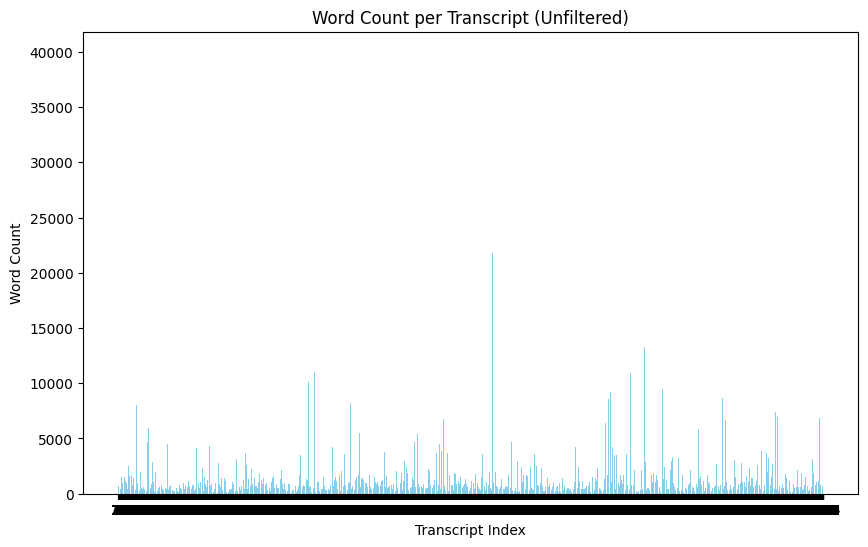

In [ ]:
import matplotlib.pyplot as plt


# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(df.index, df['word_count'], color='skyblue')
plt.xlabel('Transcript Index')
plt.ylabel('Word Count')
plt.title('Word Count per Transcript (Unfiltered)')
plt.xticks(df.index)
plt.show()


In [ ]:
# transcript with maximum words
max_word_count_row = df['word_count'].idxmax()
max_word_count_transcript = df.loc[max_word_count_row, 'transcript_unfiltered']
max_word_count_date = df.loc[max_word_count_row, 'date']
max_word_count_title = df.loc[max_word_count_row, 'title']

print(f"Row with Maximum Word Count (Index): {max_word_count_row}")
print(f"Transcript with Maximum Word Count: {max_word_count_transcript}")
print(f"Date of Transcript: {max_word_count_date}")
print(f"Title of Transcript: {max_word_count_title}")


Row with Maximum Word Count (Index): 4746
Transcript with Maximum Word Count: During the programme, the President answered more than 85 questions from Russians on the most pressing social and political issues. The total duration of the programme was 4 hours and 47 minutes. * * * Direct line programme host Kirill Kleymenov: Good afternoon, We are live with President Vladimir Putin. (Applause.) Direct line programme host Maria Sittel: Mr President, today we have invited to our studio people who are well-known throughout Russia, and some of them are your authorised representatives. Others may not be so familiar to everyone, but they are also true heroes of the day, the people who were portrayed in our television broadcasts. They are neither ministers nor artists, but rather engineers, doctors and paramedics – all real heroes of the day who live in Russia. Kirill Kleymenov: As in previous years our Direct Line will broadcast from both cities and villages. This year we will speak to the set

In [ ]:
# average length of all words
df['mean_word_length'] = df['transcript_unfiltered'].map(lambda rev: np.mean([len(word) for word in rev.split()]))
df.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Unnamed: 0                date  \
0           0 1999-12-31 00:01:00   
1           1 1999-12-31 00:02:00   
2           2 1999-12-31 00:03:00   
3           3 2000-01-04 00:00:00   
4           4 2000-01-11 00:00:00   
5           5 2000-01-15 00:00:00   
6           6 2000-01-18 00:00:00   
7           7 2000-01-18 00:00:00   
8           8 2000-01-21 00:00:00   
9           9 2000-01-23 00:00:00   

                                                                                 transcript_unfiltered  \
0  Vladimir Putin: Dear friends, On New Year’s Eve, my family and I planned to gather round the TV,...   
1  Vladimir Putin: Good afternoon, distinguished colleagues. This will be a short meeting. I am ask...   
2  Boris Yeltsin: Dear Russians, In a few hours we will see a magical date on our calendars, the ye...   
3  Question: Mr Putin, the sudden resignation of Mr Yeltsin has prompted many questions in this cou...   
4  Vladimir Putin: Dear friends, We are again gathered here today, this time on the occasion of the...   
5  Sergei Dorenko: Mr. Putin, how do you like your new office, new chair, and your new position? Ar...   
6  Question: You have said you were not indifferent to who would be State Duma Speaker. Now, you ar...   
7  Vladimir Putin: I am happy to see you in the congress hall of the State Duma. I would like to co...   
8  Vladimir Putin: Distinguished colleagues,  We last gathered together for a meeting of the Interi...   
9  Nikolai Svanidze: The most burning topic today is the situation in the State Duma. We have alrea...   

                          place  \
0           The Kremlin, Moscow   
1           The Kremlin, Moscow   
2           The Kremlin, Moscow   
3                        Moscow   
4  State Kremlin Palace, Moscow   
5                           NaN   
6                        Moscow   
7                        Moscow   
8                        Moscow   
9                           NaN   

                                                                                             title  \
0                                              New Year Address by Acting President Vladimir Putin   
1                                   Address at an expanded meeting of the Russian Security Council   
2                                                                       Statement by Boris Yeltsin   
3                                                                Interview with the ORT TV Channel   
4                          Speech at gala function marking the second millennium of Christ’s birth   
5                                                                       Interview with ORT Channel   
6  Conversation with the press during a break in the first plenary meeting of the Third State Duma   
7                                      A speech at the first plenary meeting of the 3rd State Duma   
8                            Opening remarks at a meeting of the Russian Interior Ministry’s Board   
9                                                                Interview with the RTR TV Channel   

                                                                                           no_contract  \
0  ['Vladimir', 'Putin:', 'Dear', 'friends,', 'On', 'New', 'Year’s', 'Eve,', 'my', 'family', 'and',...   
1  ['Vladimir', 'Putin:', 'Good', 'afternoon,', 'distinguished', 'colleagues.', 'This', 'will', 'be...   
2  ['Boris', 'Yeltsin:', 'Dear', 'Russians,', 'In', 'a', 'few', 'hours', 'we', 'will', 'see', 'a', ...   
3  ['Question:', 'Mr', 'Putin,', 'the', 'sudden', 'resignation', 'of', 'Mr', 'Yeltsin', 'has', 'pro...   
4  ['Vladimir', 'Putin:', 'Dear', 'friends,', 'We', 'are', 'again', 'gathered', 'here', 'today,', '...   
5  ['Sergei', 'Dorenko:', 'Mr.', 'Putin,', 'how', 'do', 'you', 'like', 'your', 'new', 'office,', 'n...   
6  ['Question:', 'You', 'have', 'said', 'you', 'were', 'not', 'indifferent', 'to', 'who', 'would', ...   
7  ['Vladimir', 'Putin:', 'I', 'am', 'happy', 'to', 'see', 'you', 'in',

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


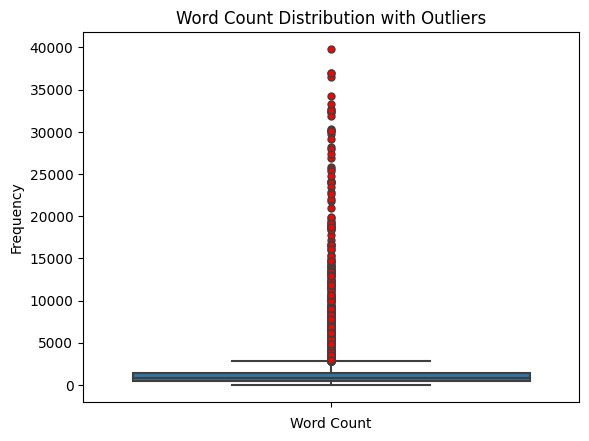

In [ ]:
# box plot of word count distribution


# Create a box plot with outliers highlighted
sns.boxplot(y=df['word_count'], flierprops={'marker': 'o', 'markerfacecolor': 'red', 'markersize': 5})

plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Word Count Distribution with Outliers')
plt.show()

In [ ]:
word_count_stats = df['word_count'].describe()
print(word_count_stats)

count     9349.000000
mean      1388.447107
std       2427.014642
min          1.000000
25%        445.000000
50%        772.000000
75%       1415.000000
max      39828.000000
Name: word_count, dtype: float64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# identify outliers


# Calculate the IQR (Interquartile Range)
Q1 = df['word_count'].quantile(0.25)
Q3 = df['word_count'].quantile(0.75)
IQR = Q3 - Q1

# Determine lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df['word_count'] < lower_bound) | (df['word_count'] > upper_bound)]



# display the count of outliers
print("Number of outliers:", len(outliers))

Number of outliers: 836


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Sort the outliers DataFrame by 'word_count' in descending order
outliers_sorted = outliers.sort_values(by='word_count', ascending=False)

# Access the top row to get the transcript with the highest word count
highest_word_count_transcript = outliers_sorted.iloc[0]

# Print the transcript with the highest word count
print("Transcript with the highest word count among outliers:")
print(highest_word_count_transcript)


Transcript with the highest word count among outliers:
Unnamed: 0                                                                                                                       4746
date                                                                                                              2013-04-25 16:50:00
transcript_unfiltered             During the programme, the President answered more than 85 questions from Russians on the most pr...
place                                                                                                                          Moscow
title                                                                                                 Direct Line with Vladimir Putin
no_contract                       ['During', 'the', 'programme,', 'the', 'President', 'answered', 'more', 'than', '85', 'questions...
transcript_unfiltered_str         During the programme, the President answered more than 85 questions from Russians on the most pr...
transcr

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


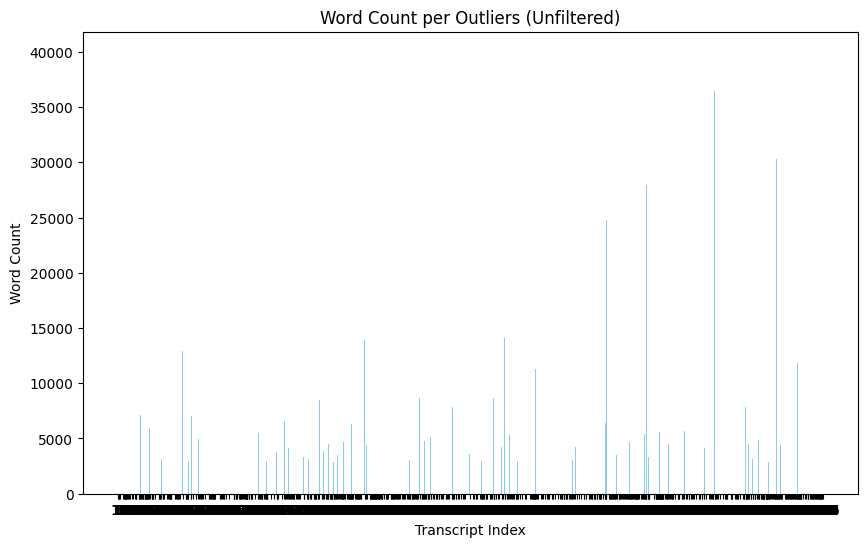

In [ ]:


# Create a bar plot for the outlier transcripts

plt.figure(figsize=(10, 6))
plt.bar(outliers.index, outliers['word_count'], color='skyblue')
plt.xlabel('Transcript Index')
plt.ylabel('Word Count')
plt.title('Word Count per Outliers (Unfiltered)')
plt.xticks(outliers.index)
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


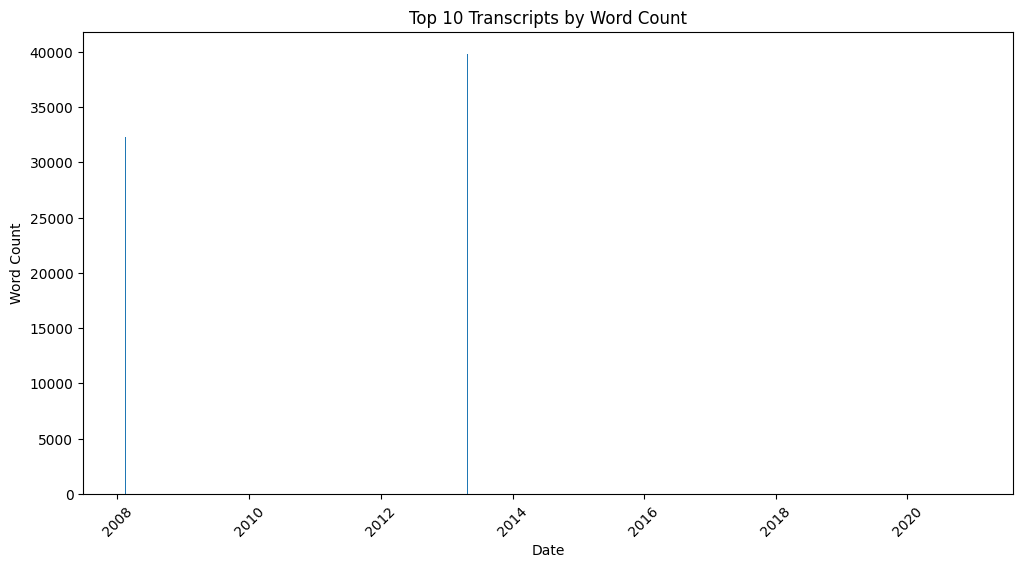

In [ ]:


# Sort the DataFrame by 'word_count' in descending order
df_sorted = df.sort_values(by='word_count', ascending=False)

# Select the top 10 transcripts
top_10_transcripts = df_sorted.head(10)

# Create a bar plot for the top 10 transcripts
plt.figure(figsize=(12, 6))
plt.bar(top_10_transcripts['date'], top_10_transcripts['word_count'])
plt.xlabel('Date')
plt.ylabel('Word Count')
plt.title('Top 10 Transcripts by Word Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


In [ ]:
print(top_10_transcripts['date'], top_10_transcripts['title'])


4746   2013-04-25 16:50:00
8559   2020-12-17 16:35:00
4583   2012-12-20 16:40:00
7908   2019-06-20 16:20:00
7353   2018-06-07 16:30:00
8195   2019-12-19 16:20:00
5698   2015-04-16 15:55:00
6812   2017-06-15 16:00:00
2216   2008-02-14 10:11:00
5098   2013-12-19 17:00:00
Name: date, dtype: datetime64[ns] 4746              Direct Line with Vladimir Putin
8559      Vladimir Putin’s annual news conference
4583            News conference of Vladimir Putin
7908              Direct Line with Vladimir Putin
7353              Direct Line with Vladimir Putin
8195      Vladimir Putin’s annual news conference
5698              Direct Line with Vladimir Putin
6812              Direct Line with Vladimir Putin
2216    Transcript of Annual Big Press Conference
5098            News conference of Vladimir Putin
Name: title, dtype: object


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# identify the most words in a transcript
most_words = df['word_count'].max()
print(f"Most words in a transcript: {most_words}")

# Find the index of the transcript with the maximum word count
max_word_count_index = df['word_count'].idxmax()

# Access the transcript with the maximum word count
transcript_with_max_words = df.loc[max_word_count_index, 'title']
date_with_max_words = df.loc[max_word_count_index, 'date']

print("Transcript with the most words:")
print(transcript_with_max_words)
print("Date of transcript:")
print(date_with_max_words)


Most words in a transcript: 39828
Transcript with the most words:
Direct Line with Vladimir Putin
Date of transcript:
2013-04-25 16:50:00


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


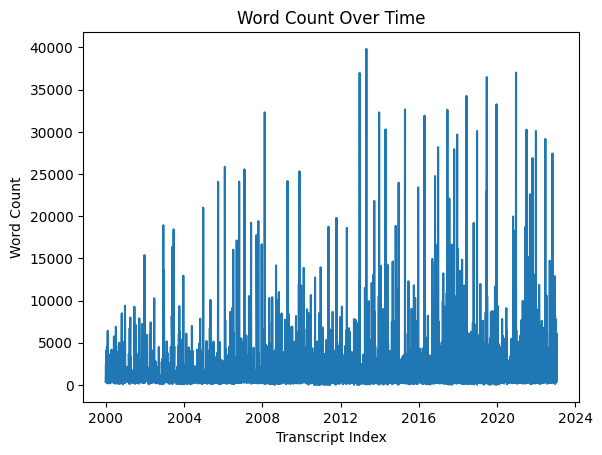

In [ ]:
# plot word count over time

plt.plot(df.date, df['word_count'])
plt.xlabel('Transcript Index')
plt.ylabel('Word Count')
plt.title('Word Count Over Time')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


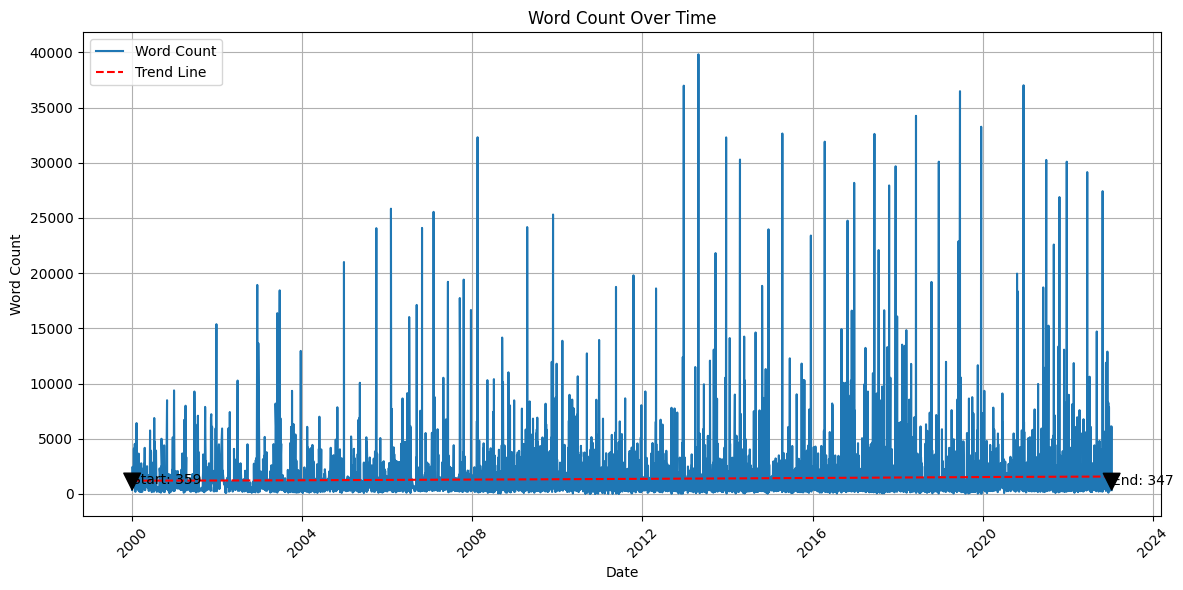

In [ ]:

from sklearn.linear_model import LinearRegression


# Extract the date and word_count columns
dates = df['date']
word_counts = df['word_count']

# Perform linear regression
model = LinearRegression()
X = np.arange(len(dates)).reshape(-1, 1)
model.fit(X, word_counts)
predicted = model.predict(X)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(dates, word_counts, label='Word Count')
plt.plot(dates, predicted, color='red', linestyle='--', label='Trend Line')

# Annotate the start and end points with word counts
start_word_count = word_counts.iloc[0]
end_word_count = word_counts.iloc[-1]
plt.annotate(f'Start: {start_word_count}', xy=(dates.iloc[0], start_word_count),
             xytext=(dates.iloc[0], start_word_count + 500),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=10)
plt.annotate(f'End: {end_word_count}', xy=(dates.iloc[-1], end_word_count),
             xytext=(dates.iloc[-1], end_word_count + 500),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=10)

plt.xlabel('Date')
plt.ylabel('Word Count')
plt.title('Word Count Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



In [10]:
# count of words that aren't stop words


df['word_count_minusstopwords'] = df['stopwords_removed'].map(lambda rev: len(rev.split()))
df.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Unnamed: 0                date persons                         place  \
0           0 1999-12-31 00:01:00      []           The Kremlin, Moscow   
1           1 1999-12-31 00:02:00      []           The Kremlin, Moscow   
2           2 1999-12-31 00:03:00      []           The Kremlin, Moscow   
3           3 2000-01-04 00:00:00      []                        Moscow   
4           4 2000-01-11 00:00:00      []  State Kremlin Palace, Moscow   
5           5 2000-01-15 00:00:00      []                           NaN   
6           6 2000-01-18 00:00:00      []                        Moscow   
7           7 2000-01-18 00:00:00      []                        Moscow   
8           8 2000-01-21 00:00:00      []                        Moscow   
9           9 2000-01-23 00:00:00      []                           NaN   

                                                                                             title  \
0                                              New Year Address by Acting President Vladimir Putin   
1                                   Address at an expanded meeting of the Russian Security Council   
2                                                                       Statement by Boris Yeltsin   
3                                                                Interview with the ORT TV Channel   
4                          Speech at gala function marking the second millennium of Christ’s birth   
5                                                                       Interview with ORT Channel   
6  Conversation with the press during a break in the first plenary meeting of the Third State Duma   
7                                      A speech at the first plenary meeting of the 3rd State Duma   
8                            Opening remarks at a meeting of the Russian Interior Ministry’s Board   
9                                                                Interview with the RTR TV Channel   

  langs  \
0    en   
1    en   
2    en   
3    en   
4    en   
5    en   
6    en   
7    en   
8    en   
9    en   

                                                                        transcripts_sentence_tokenized  \
0  ['Vladimir Putin: Dear friends, On New Year’s Eve, my family and I planned to gather round the T...   
1  ['Vladimir Putin: Good afternoon, distinguished colleagues.', 'This will be a short meeting.', '...   
2  ['Boris Yeltsin: Dear Russians, In a few hours we will see a magical date on our calendars, the ...   
3  ['Question: Mr Putin, the sudden resignation of Mr Yeltsin has prompted many questions in this c...   
4  ['Vladimir Putin: Dear friends, We are again gathered here today, this time on the occasion of t...   
5  ['Sergei Dorenko: Mr. Putin, how do you like your new office, new chair, and your new position?'...   
6  ['Question: You have said you were not indifferent to who would be State Duma Speaker.', 'Now, y...   
7  ['Vladimir Putin: I am happy to see you in the congress hall of the State Duma.', 'I would like ...   
8  ['Vladimir Putin: Distinguished colleagues, We last gathered together for a meeting of the Inter...   
9  ['Nikolai Svanidze: The most burning topic today is the situation in the State Duma.', 'We have ...   

                                                                                     stopwords_removed  \
0  ['vladimir', 'putin', 'dear', 'friends', 'new', 'year', '’', 'eve', 'family', 'planned', 'gather...   
1  ['vladimir', 'putin', 'good', 'afternoon', 'distinguished', 'colleagues', 'short', 'meeting', 'a...   
2  ['boris', 'yeltsin', 'dear', 'russians', 'hours', 'see', 'magical', 'date', 'calendars', 'year',...   
3  ['question', 'mr', 'putin', 'sudden', 'resignation', 'mr', 'yeltsin', 'prompted', 'many', 'quest...   
4  ['vladimir', 'putin', 'dear', 'friends', 'gathered', 'today', 'time', 'occasion', 'joyful', 'cel...   
5  ['sergei', 'dorenko', 'mr.', 'putin', 'like', 'new', 'office', 'new', 'chair', 'new', 'position'...   
6  ['question', 'said',

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


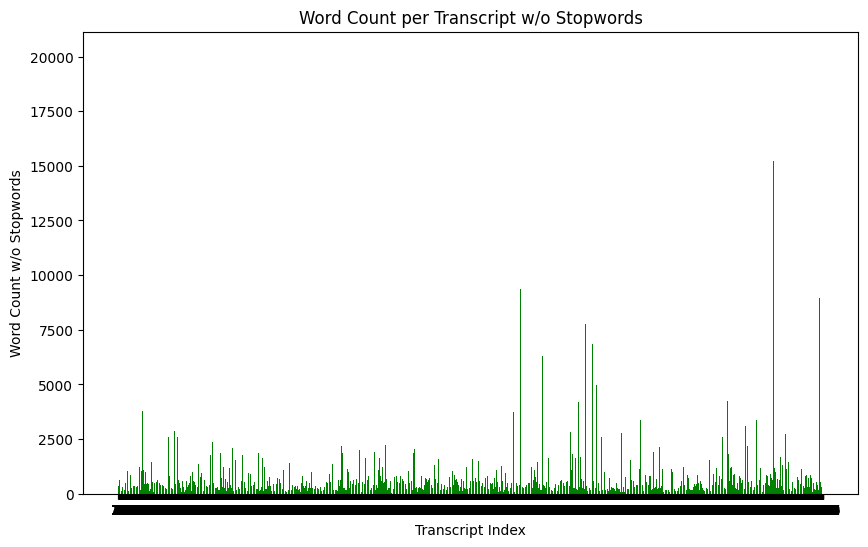

In [11]:
# length of words that aren't stop words

import matplotlib.pyplot as plt


# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(df.index, df['word_count_minusstopwords'], color='green')
plt.xlabel('Transcript Index')
plt.ylabel('Word Count w/o Stopwords')
plt.title('Word Count per Transcript w/o Stopwords')
plt.xticks(df.index)
plt.show()


In [12]:
# split off year and month from date

df['Year'] = df['date'].dt.year
df['Month'] = df['date'].dt.month

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Unnamed: 0                date persons                         place  \
0           0 1999-12-31 00:01:00      []           The Kremlin, Moscow   
1           1 1999-12-31 00:02:00      []           The Kremlin, Moscow   
2           2 1999-12-31 00:03:00      []           The Kremlin, Moscow   
3           3 2000-01-04 00:00:00      []                        Moscow   
4           4 2000-01-11 00:00:00      []  State Kremlin Palace, Moscow   

                                                                     title  \
0                      New Year Address by Acting President Vladimir Putin   
1           Address at an expanded meeting of the Russian Security Council   
2                                               Statement by Boris Yeltsin   
3                                        Interview with the ORT TV Channel   
4  Speech at gala function marking the second millennium of Christ’s birth   

  langs  \
0    en   
1    en   
2    en   
3    en   
4    en   

                                                                        transcripts_sentence_tokenized  \
0  ['Vladimir Putin: Dear friends, On New Year’s Eve, my family and I planned to gather round the T...   
1  ['Vladimir Putin: Good afternoon, distinguished colleagues.', 'This will be a short meeting.', '...   
2  ['Boris Yeltsin: Dear Russians, In a few hours we will see a magical date on our calendars, the ...   
3  ['Question: Mr Putin, the sudden resignation of Mr Yeltsin has prompted many questions in this c...   
4  ['Vladimir Putin: Dear friends, We are again gathered here today, this time on the occasion of t...   

                                                                                     stopwords_removed  \
0  ['vladimir', 'putin', 'dear', 'friends', 'new', 'year', '’', 'eve', 'family', 'planned', 'gather...   
1  ['vladimir', 'putin', 'good', 'afternoon', 'distinguished', 'colleagues', 'short', 'meeting', 'a...   
2  ['boris', 'yeltsin', 'dear', 'russians', 'hours', 'see', 'magical', 'date', 'calendars', 'year',...   
3  ['question', 'mr', 'putin', 'sudden', 'resignation', 'mr', 'yeltsin', 'prompted', 'many', 'quest...   
4  ['vladimir', 'putin', 'dear', 'friends', 'gathered', 'today', 'time', 'occasion', 'joyful', 'cel...   

                                                                                              pos_tags  \
0  [('vladimir', 'NN'), ('putin', 'NN'), ('dear', 'JJ'), ('friends', 'NNS'), ('new', 'JJ'), ('year'...   
1  [('vladimir', 'NN'), ('putin', 'NN'), ('good', 'JJ'), ('afternoon', 'NN'), ('distinguished', 'VB...   
2  [('boris', 'NN'), ('yeltsin', 'NN'), ('dear', 'JJ'), ('russians', 'NNS'), ('hours', 'NNS'), ('se...   
3  [('question', 'NN'), ('mr', 'NN'), ('putin', 'NN'), ('sudden', 'JJ'), ('resignation', 'NN'), ('m...   
4  [('vladimir', 'NN'), ('putin', 'NN'), ('dear', 'JJ'), ('friends', 'NNS'), ('gathered', 'VBN'), (...   

                                                                                           wordnet_pos  \
0  [('vladimir', 'n'), ('putin', 'n'), ('dear', 'a'), ('friends', 'n'), ('new', 'a'), ('year', 'n')...   
1  [('vladimir', 'n'), ('putin', 'n'), ('good', 'a'), ('afternoon', 'n'), ('distinguished', 'v'), (...   
2  [('boris', 'n'), ('yeltsin', 'n'), ('dear', 'a'), ('russians', 'n'), ('hours', 'n'), ('see', 'v'...   
3  [('question', 'n'), ('mr', 'n'), ('putin', 'n'), ('sudden', 'a'), ('resignation', 'n'), ('mr', '...   
4  [('vladimir', 'n'), ('putin', 'n'), ('dear', 'a'), ('friends', 'n'), ('gathered', 'v'), ('today'...   

                                                                                            lemmatized  \
0  ['vladimir', 'putin', 'dear', 'friend', 'new', 'year', '’', 'eve', 'family', 'plan', 'gather', '...   
1  ['vladimir', 'putin', 'good', 'afternoon', 'distinguish', 'colleague', 'short', 'meeting', 'ask'...   
2  ['boris', 'yeltsin', 'dear', 'russian', 'hour', 'see', 'magical', 'date', 'calendar', 'year', '2...   
3  ['question', 'mr', 'putin', 'sudden', 're

### Search for Transcripts with Specific Words/Phrases

In [18]:
# define function to search each transcript (by row in column---citation:  ChatGPT)

import re

def find_keywords_phrases(text):
    keywords = ["ukraine", "nato", "colour revolution", "colour revolutions", "coloured revolutions",
                "coloured revolution", "missile defense",
            "military", "technical", "crimea", "china", "chinese", "xi", "jiang", "prc"]

    found_keywords = [keyword for keyword in keywords if re.search(r'\b' + re.escape(keyword) + r'\b', text, re.I)]

    return found_keywords


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
# apply function and create column to store results

df['found_keywords'] = df['stopwords_removed'].apply(find_keywords_phrases)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Unnamed: 0                date persons                         place  \
0           0 1999-12-31 00:01:00      []           The Kremlin, Moscow   
1           1 1999-12-31 00:02:00      []           The Kremlin, Moscow   
2           2 1999-12-31 00:03:00      []           The Kremlin, Moscow   
3           3 2000-01-04 00:00:00      []                        Moscow   
4           4 2000-01-11 00:00:00      []  State Kremlin Palace, Moscow   

                                                                     title  \
0                      New Year Address by Acting President Vladimir Putin   
1           Address at an expanded meeting of the Russian Security Council   
2                                               Statement by Boris Yeltsin   
3                                        Interview with the ORT TV Channel   
4  Speech at gala function marking the second millennium of Christ’s birth   

  langs  \
0    en   
1    en   
2    en   
3    en   
4    en   

                                                                        transcripts_sentence_tokenized  \
0  ['Vladimir Putin: Dear friends, On New Year’s Eve, my family and I planned to gather round the T...   
1  ['Vladimir Putin: Good afternoon, distinguished colleagues.', 'This will be a short meeting.', '...   
2  ['Boris Yeltsin: Dear Russians, In a few hours we will see a magical date on our calendars, the ...   
3  ['Question: Mr Putin, the sudden resignation of Mr Yeltsin has prompted many questions in this c...   
4  ['Vladimir Putin: Dear friends, We are again gathered here today, this time on the occasion of t...   

                                                                                     stopwords_removed  \
0  ['vladimir', 'putin', 'dear', 'friends', 'new', 'year', '’', 'eve', 'family', 'planned', 'gather...   
1  ['vladimir', 'putin', 'good', 'afternoon', 'distinguished', 'colleagues', 'short', 'meeting', 'a...   
2  ['boris', 'yeltsin', 'dear', 'russians', 'hours', 'see', 'magical', 'date', 'calendars', 'year',...   
3  ['question', 'mr', 'putin', 'sudden', 'resignation', 'mr', 'yeltsin', 'prompted', 'many', 'quest...   
4  ['vladimir', 'putin', 'dear', 'friends', 'gathered', 'today', 'time', 'occasion', 'joyful', 'cel...   

                                                                                              pos_tags  \
0  [('vladimir', 'NN'), ('putin', 'NN'), ('dear', 'JJ'), ('friends', 'NNS'), ('new', 'JJ'), ('year'...   
1  [('vladimir', 'NN'), ('putin', 'NN'), ('good', 'JJ'), ('afternoon', 'NN'), ('distinguished', 'VB...   
2  [('boris', 'NN'), ('yeltsin', 'NN'), ('dear', 'JJ'), ('russians', 'NNS'), ('hours', 'NNS'), ('se...   
3  [('question', 'NN'), ('mr', 'NN'), ('putin', 'NN'), ('sudden', 'JJ'), ('resignation', 'NN'), ('m...   
4  [('vladimir', 'NN'), ('putin', 'NN'), ('dear', 'JJ'), ('friends', 'NNS'), ('gathered', 'VBN'), (...   

                                                                                           wordnet_pos  \
0  [('vladimir', 'n'), ('putin', 'n'), ('dear', 'a'), ('friends', 'n'), ('new', 'a'), ('year', 'n')...   
1  [('vladimir', 'n'), ('putin', 'n'), ('good', 'a'), ('afternoon', 'n'), ('distinguished', 'v'), (...   
2  [('boris', 'n'), ('yeltsin', 'n'), ('dear', 'a'), ('russians', 'n'), ('hours', 'n'), ('see', 'v'...   
3  [('question', 'n'), ('mr', 'n'), ('putin', 'n'), ('sudden', 'a'), ('resignation', 'n'), ('mr', '...   
4  [('vladimir', 'n'), ('putin', 'n'), ('dear', 'a'), ('friends', 'n'), ('gathered', 'v'), ('today'...   

                                                                                            lemmatized  \
0  ['vladimir', 'putin', 'dear', 'friend', 'new', 'year', '’', 'eve', 'family', 'plan', 'gather', '...   
1  ['vladimir', 'putin', 'good', 'afternoon', 'distinguish', 'colleague', 'short', 'meeting', 'ask'...   
2  ['boris', 'yeltsin', 'dear', 'russian', 'hour', 'see', 'magical', 'date', 'calendar', 'year', '2...   
3  ['question', 'mr', 'putin', 'sudden', 're

In [21]:
# Find transcripts that have keywords

# Filter the DataFrame to include only rows with non-empty "found_keywords"
filtered_df = df[df['found_keywords'].apply(lambda x: len(x) > 0)]




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
filtered_df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Unnamed: 0                date persons                place  \
1            1 1999-12-31 00:02:00      []  The Kremlin, Moscow   
3            3 2000-01-04 00:00:00      []               Moscow   
5            5 2000-01-15 00:00:00      []                  NaN   
9            9 2000-01-23 00:00:00      []                  NaN   
10          10 2000-01-24 00:00:00      []               Moscow   

                                                                    title  \
1          Address at an expanded meeting of the Russian Security Council   
3                                       Interview with the ORT TV Channel   
5                                              Interview with ORT Channel   
9                                       Interview with the RTR TV Channel   
10  Speech at a conference of the heads of republican and regional courts   

   langs  \
1     en   
3     en   
5     en   
9     en   
10    en   

                                                                         transcripts_sentence_tokenized  \
1   ['Vladimir Putin: Good afternoon, distinguished colleagues.', 'This will be a short meeting.', '...   
3   ['Question: Mr Putin, the sudden resignation of Mr Yeltsin has prompted many questions in this c...   
5   ['Sergei Dorenko: Mr. Putin, how do you like your new office, new chair, and your new position?'...   
9   ['Nikolai Svanidze: The most burning topic today is the situation in the State Duma.', 'We have ...   
10  ['Vladimir Putin: Esteemed Mr Lebedev, Ladies and Gentlemen: You have gathered here to sum up th...   

                                                                                      stopwords_removed  \
1   ['vladimir', 'putin', 'good', 'afternoon', 'distinguished', 'colleagues', 'short', 'meeting', 'a...   
3   ['question', 'mr', 'putin', 'sudden', 'resignation', 'mr', 'yeltsin', 'prompted', 'many', 'quest...   
5   ['sergei', 'dorenko', 'mr.', 'putin', 'like', 'new', 'office', 'new', 'chair', 'new', 'position'...   
9   ['nikolai', 'svanidze', 'burning', 'topic', 'today', 'situation', 'state', 'duma', 'already', 'h...   
10  ['vladimir', 'putin', 'esteemed', 'mr', 'lebedev', 'ladies', 'gentlemen', 'gathered', 'sum', 're...   

                                                                                               pos_tags  \
1   [('vladimir', 'NN'), ('putin', 'NN'), ('good', 'JJ'), ('afternoon', 'NN'), ('distinguished', 'VB...   
3   [('question', 'NN'), ('mr', 'NN'), ('putin', 'NN'), ('sudden', 'JJ'), ('resignation', 'NN'), ('m...   
5   [('sergei', 'NN'), ('dorenko', 'VBZ'), ('mr.', 'JJ'), ('putin', 'NNS'), ('like', 'IN'), ('new', ...   
9   [('nikolai', 'JJ'), ('svanidze', 'NN'), ('burning', 'VBG'), ('topic', 'NN'), ('today', 'NN'), ('...   
10  [('vladimir', 'NN'), ('putin', 'NN'), ('esteemed', 'VBD'), ('mr', 'JJ'), ('lebedev', 'JJ'), ('la...   

                                                                                            wordnet_pos  \
1   [('vladimir', 'n'), ('putin', 'n'), ('good', 'a'), ('afternoon', 'n'), ('distinguished', 'v'), (...   
3   [('question', 'n'), ('mr', 'n'), ('putin', 'n'), ('sudden', 'a'), ('resignation', 'n'), ('mr', '...   
5   [('sergei', 'n'), ('dorenko', 'v'), ('mr.', 'a'), ('putin', 'n'), ('like', 'n'), ('new', 'a'), (...   
9   [('nikolai', 'a'), ('svanidze', 'n'), ('burning', 'v'), ('topic', 'n'), ('today', 'n'), ('situat...   
10  [('vladimir', 'n'), ('putin', 'n'), ('esteemed', 'v'), ('mr', 'a'), ('lebedev', 'a'), ('ladies',...   

                                                                                             lemmatized  \
1   ['vladimir', 'putin', 'good', 'afternoon', 'distinguish', 'colleague', 'short', 'meeting', 'ask'...   
3   ['question', 'mr', 'putin', 'sudden', 'resignation', 'mr', 'yeltsin', 'prompt', 'many', 'questio...   
5   ['sergei', 'dorenko', 'mr.', 'putin', 'like', 'new', 'office', 'new', 'chair', 'new', 'position'...   
9   ['nikolai', 'svanidze', 'burn', 'topic', 'today', 'situation'

In [23]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4450 entries, 1 to 9620
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Unnamed: 0                      4450 non-null   int64         
 1   date                            4450 non-null   datetime64[ns]
 2   persons                         4450 non-null   object        
 3   place                           4098 non-null   object        
 4   title                           4450 non-null   object        
 5   langs                           4450 non-null   object        
 6   transcripts_sentence_tokenized  4450 non-null   object        
 7   stopwords_removed               4450 non-null   object        
 8   pos_tags                        4450 non-null   object        
 9   wordnet_pos                     4450 non-null   object        
 10  lemmatized                      4450 non-null   object        
 11  word_coun

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [57]:
# Check for transcripts that contain "xi" or "prc" but not "china"
filtered_results = filtered_df[
    ((filtered_df['stopwords_removed'].str.contains(r'\bxi\b')) |
     (filtered_df['stopwords_removed'].str.contains(r'\bprc\b'))) &
    (~filtered_df['stopwords_removed'].str.contains(r'\bchina\b'))
]

# Display the results
filtered_results


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Unnamed: 0                date persons                 place  \
222          222 2001-02-27 00:00:00      []                   NaN   
668          668 2003-05-29 00:01:00      []   The Kremlin, Moscow   
2083        2083 2007-10-02 13:45:00      []   The Kremlin, Moscow   
2204        2204 2008-02-05 10:25:00      []                 Sochi   
2682        2682 2009-01-08 19:02:00      []                 Sochi   
3132        3132 2009-10-21 14:10:00      []   The Kremlin, Moscow   
3138        3138 2009-10-23 19:34:00      []                 Kazan   
3257        3257 2010-02-03 14:42:00      []  Gorki, Moscow Region   
4632        4632 2013-02-07 21:30:00      []                 Sochi   
5180        5180 2014-03-07 20:00:00      []                 Sochi   
5200        5200 2014-03-24 16:25:00      []   The Kremlin, Moscow   
5620        5620 2015-02-07 21:00:00      []                 Sochi   
6911        6911 2017-08-20 20:10:00      []                Crimea   
7831        7831 2019-04-26 07:45:00      []               Beijing   
8137        8137 2019-11-14 19:00:00      []              Brasilia   
8846        8846 2021-10-12 09:30:00      []                   NaN   
8855        8855 2021-10-14 15:40:00      []                   NaN   

                                                                                                    title  \
222                                                Written Interview to the Vietnamese Newspaper Nhan Dan   
668         Speech at a Meeting of the Council of Heads of State of the Shanghai Cooperation Organisation   
2083  Opening remarks at Meeting of the Presidential Council for the Development of Physical Culture a...   
2204  Answering journalists' questions after examining part of the highway that is being built around ...   
2682                          Beginning of the Meeting on the Preparations for the 2014 Olympics in Sochi   
3132  Excerpts from Transcript of Meeting with Members of the Russian Union of Industrialists and Entr...   
3138                          Opening Remarks at Meeting with Heads of International Sports Organisations   
3257  Beginning of Meeting with Minister of Sport, Tourism, and Youth Policy Vitaly Mutko and Presiden...   
4632                                                Exactly one year remains until Olympic Games in Sochi   
5180                                              Meeting with International Paralympic Committee members   
5200                                                      Presenting Russian Federation state decorations   
5620                                          Celebration of one year since the opening of Sochi Olympics   
6911                                                             Tavrida National Youth Educational Forum   
7831                                    Vladimir Putin received honorary doctorate at Tsinghua University   
8137                      Meeting with BRICS Business Council members and New Development Bank management   
8846  Address to the 15th meeting of the Conference of the Parties to the UN Convention on Biological ...   
8855                         Address to participants of Second UN Global Sustainable Transport Conference   

     langs  \
222     en   
668     en   
2083    en   
2204    en   
2682    en   
3132    en   
3138    en   
3257    en   
4632    en   
5180    en   
5200    en   
5620    en   
6911    en   
7831    en   
8137    en   
8846    en   
8855    en   

                                                                           transcripts_sentence_tokenized  \
222   ['Question: In connection with your historic visit to Vietnam, we would like to ask you about th...   
668   ['Vladimir Putin: Mr Chairman, Distinguished heads of state, Friends, I have already said that a...   
2083  ['President Vladimir Putin: Good afternoon, dear colleagues!', 'We are meeting today to update t...   
2204  ['Question: Vladimir Vladimirovich, what are your impressions of the Council meeting [C

In [58]:
filtered_results.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17 entries, 222 to 8855
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Unnamed: 0                      17 non-null     int64         
 1   date                            17 non-null     datetime64[ns]
 2   persons                         17 non-null     object        
 3   place                           14 non-null     object        
 4   title                           17 non-null     object        
 5   langs                           17 non-null     object        
 6   transcripts_sentence_tokenized  17 non-null     object        
 7   stopwords_removed               17 non-null     object        
 8   pos_tags                        17 non-null     object        
 9   wordnet_pos                     17 non-null     object        
 10  lemmatized                      17 non-null     object        
 11  word_coun

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
# split off year and month from date

filtered_df['Year'] = filtered_df['date'].dt.year
filtered_df['Month'] = filtered_df['date'].dt.month

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
filtered_df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Unnamed: 0                date persons                place  \
1            1 1999-12-31 00:02:00      []  The Kremlin, Moscow   
3            3 2000-01-04 00:00:00      []               Moscow   
5            5 2000-01-15 00:00:00      []                  NaN   
9            9 2000-01-23 00:00:00      []                  NaN   
10          10 2000-01-24 00:00:00      []               Moscow   

                                                                    title  \
1          Address at an expanded meeting of the Russian Security Council   
3                                       Interview with the ORT TV Channel   
5                                              Interview with ORT Channel   
9                                       Interview with the RTR TV Channel   
10  Speech at a conference of the heads of republican and regional courts   

   langs  \
1     en   
3     en   
5     en   
9     en   
10    en   

                                                                         transcripts_sentence_tokenized  \
1   ['Vladimir Putin: Good afternoon, distinguished colleagues.', 'This will be a short meeting.', '...   
3   ['Question: Mr Putin, the sudden resignation of Mr Yeltsin has prompted many questions in this c...   
5   ['Sergei Dorenko: Mr. Putin, how do you like your new office, new chair, and your new position?'...   
9   ['Nikolai Svanidze: The most burning topic today is the situation in the State Duma.', 'We have ...   
10  ['Vladimir Putin: Esteemed Mr Lebedev, Ladies and Gentlemen: You have gathered here to sum up th...   

                                                                                      stopwords_removed  \
1   ['vladimir', 'putin', 'good', 'afternoon', 'distinguished', 'colleagues', 'short', 'meeting', 'a...   
3   ['question', 'mr', 'putin', 'sudden', 'resignation', 'mr', 'yeltsin', 'prompted', 'many', 'quest...   
5   ['sergei', 'dorenko', 'mr.', 'putin', 'like', 'new', 'office', 'new', 'chair', 'new', 'position'...   
9   ['nikolai', 'svanidze', 'burning', 'topic', 'today', 'situation', 'state', 'duma', 'already', 'h...   
10  ['vladimir', 'putin', 'esteemed', 'mr', 'lebedev', 'ladies', 'gentlemen', 'gathered', 'sum', 're...   

                                                                                               pos_tags  \
1   [('vladimir', 'NN'), ('putin', 'NN'), ('good', 'JJ'), ('afternoon', 'NN'), ('distinguished', 'VB...   
3   [('question', 'NN'), ('mr', 'NN'), ('putin', 'NN'), ('sudden', 'JJ'), ('resignation', 'NN'), ('m...   
5   [('sergei', 'NN'), ('dorenko', 'VBZ'), ('mr.', 'JJ'), ('putin', 'NNS'), ('like', 'IN'), ('new', ...   
9   [('nikolai', 'JJ'), ('svanidze', 'NN'), ('burning', 'VBG'), ('topic', 'NN'), ('today', 'NN'), ('...   
10  [('vladimir', 'NN'), ('putin', 'NN'), ('esteemed', 'VBD'), ('mr', 'JJ'), ('lebedev', 'JJ'), ('la...   

                                                                                            wordnet_pos  \
1   [('vladimir', 'n'), ('putin', 'n'), ('good', 'a'), ('afternoon', 'n'), ('distinguished', 'v'), (...   
3   [('question', 'n'), ('mr', 'n'), ('putin', 'n'), ('sudden', 'a'), ('resignation', 'n'), ('mr', '...   
5   [('sergei', 'n'), ('dorenko', 'v'), ('mr.', 'a'), ('putin', 'n'), ('like', 'n'), ('new', 'a'), (...   
9   [('nikolai', 'a'), ('svanidze', 'n'), ('burning', 'v'), ('topic', 'n'), ('today', 'n'), ('situat...   
10  [('vladimir', 'n'), ('putin', 'n'), ('esteemed', 'v'), ('mr', 'a'), ('lebedev', 'a'), ('ladies',...   

                                                                                             lemmatized  \
1   ['vladimir', 'putin', 'good', 'afternoon', 'distinguish', 'colleague', 'short', 'meeting', 'ask'...   
3   ['question', 'mr', 'putin', 'sudden', 'resignation', 'mr', 'yeltsin', 'prompt', 'many', 'questio...   
5   ['sergei', 'dorenko', 'mr.', 'putin', 'like', 'new', 'office', 'new', 'chair', 'new', 'position'...   
9   ['nikolai', 'svanidze', 'burn', 'topic', 'today', 'situation'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


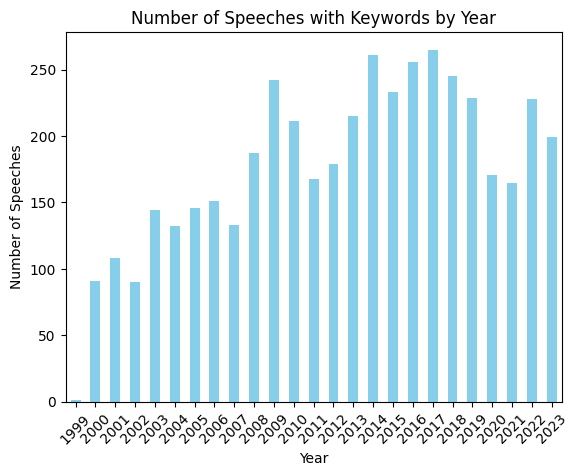

In [26]:
# Group the speeches by year and count occurrences
speeches_by_year = filtered_df.groupby(filtered_df['Year']).size()

# To group by month, use this line instead:
# speeches_by_month = filtered_speeches.groupby(filtered_speeches['year'].dt.to_period('M')).size()

# Plotting
speeches_by_year.plot(kind='bar', color='skyblue')
plt.title('Number of Speeches with Keywords by Year')
plt.xlabel('Year')
plt.ylabel('Number of Speeches')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


In [27]:
# Create a list of transcripts from the "title" column for the filtered rows
transcripts_with_keywords = filtered_df['title'].tolist()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
len(transcripts_with_keywords)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


4450

In [29]:
# find transcripts with nato

filtered_nato = filtered_df[filtered_df['found_keywords'].apply(lambda x: 'nato' in x)]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
len(filtered_nato)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


545

In [31]:
filtered_nato.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Unnamed: 0                date persons  \
5            5 2000-01-15 00:00:00      []   
9            9 2000-01-23 00:00:00      []   
16          16 2000-02-04 00:00:00      []   
37          37 2000-03-05 14:26:00      []   
84          84 2000-06-02 00:00:00      []   

                                  place  \
5                                   NaN   
9                                   NaN   
16                               Moscow   
37  Courtesy "BBC Breakfast with Frost"   
84                                  NaN   

                                                                     title  \
5                                               Interview with ORT Channel   
9                                        Interview with the RTR TV Channel   
16                           Opening Address to a Security Council Meeting   
37                                 Interview to “BBC Breakfast with Frost”   
84  From the Transcript of an Interview with the American NBC News Channel   

   langs  \
5     en   
9     en   
16    en   
37    en   
84    en   

                                                                         transcripts_sentence_tokenized  \
5   ['Sergei Dorenko: Mr. Putin, how do you like your new office, new chair, and your new position?'...   
9   ['Nikolai Svanidze: The most burning topic today is the situation in the State Duma.', 'We have ...   
16  ['Vladimir Putin: Good morning.', 'We have many important issues on our agenda, and these includ...   
37  ['David Frost: In his first television interview with a Western or indeed a foreign journalist s...   
84  ['On the Presidency Question: Mr President, before you took office you were known mainly to your...   

                                                                                      stopwords_removed  \
5   ['sergei', 'dorenko', 'mr.', 'putin', 'like', 'new', 'office', 'new', 'chair', 'new', 'position'...   
9   ['nikolai', 'svanidze', 'burning', 'topic', 'today', 'situation', 'state', 'duma', 'already', 'h...   
16  ['vladimir', 'putin', 'good', 'morning', 'many', 'important', 'issues', 'agenda', 'include', 'mi...   
37  ['david', 'frost', 'first', 'television', 'interview', 'western', 'indeed', 'foreign', 'journali...   
84  ['presidency', 'question', 'mr', 'president', 'took', 'office', 'known', 'mainly', 'family', 'fr...   

                                                                                               pos_tags  \
5   [('sergei', 'NN'), ('dorenko', 'VBZ'), ('mr.', 'JJ'), ('putin', 'NNS'), ('like', 'IN'), ('new', ...   
9   [('nikolai', 'JJ'), ('svanidze', 'NN'), ('burning', 'VBG'), ('topic', 'NN'), ('today', 'NN'), ('...   
16  [('vladimir', 'NN'), ('putin', 'NN'), ('good', 'JJ'), ('morning', 'NN'), ('many', 'JJ'), ('impor...   
37  [('david', 'NN'), ('frost', 'NN'), ('first', 'JJ'), ('television', 'NN'), ('interview', 'NN'), (...   
84  [('presidency', 'NN'), ('question', 'NN'), ('mr', 'NN'), ('president', 'NN'), ('took', 'VBD'), (...   

                                                                                            wordnet_pos  \
5   [('sergei', 'n'), ('dorenko', 'v'), ('mr.', 'a'), ('putin', 'n'), ('like', 'n'), ('new', 'a'), (...   
9   [('nikolai', 'a'), ('svanidze', 'n'), ('burning', 'v'), ('topic', 'n'), ('today', 'n'), ('situat...   
16  [('vladimir', 'n'), ('putin', 'n'), ('good', 'a'), ('morning', 'n'), ('many', 'a'), ('important'...   
37  [('david', 'n'), ('frost', 'n'), ('first', 'a'), ('television', 'n'), ('interview', 'n'), ('west...   
84  [('presidency', 'n'), ('question', 'n'), ('mr', 'n'), ('president', 'n'), ('took', 'v'), ('offic...   

                                                                                             lemmatized  \
5   ['sergei', 'dorenko', 'mr.', 'putin', 'like', 'new', 'office', 'new', 'chair', 'new', 'position'...   
9   ['nikolai', 'svanidze', 'burn', 'topic', 'today', 'situation', 'state', 'duma', 'already', 'hear...   
16  ['vladimir', 'putin', 'good',

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


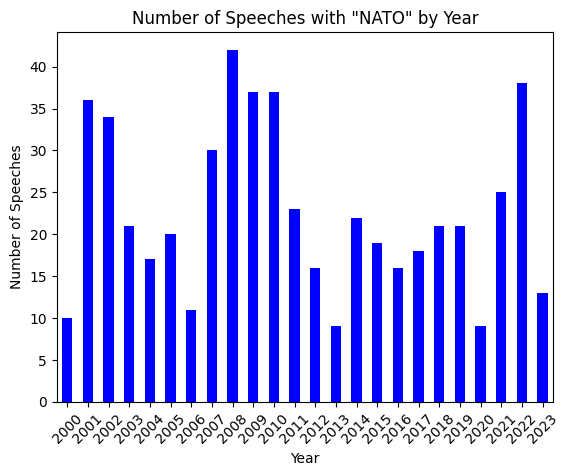

In [32]:
# plot speeches with "NATO"

# Group the speeches by year and count occurrences
speeches_by_year_nato = filtered_nato.groupby(filtered_nato['Year']).size()

# To group by month, use this line instead:
# speeches_by_month = filtered_speeches.groupby(filtered_speeches['year'].dt.to_period('M')).size()

# Plotting
speeches_by_year_nato.plot(kind='bar', color='blue')
plt.title('Number of Speeches with "NATO" by Year')
plt.xlabel('Year')
plt.ylabel('Number of Speeches')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


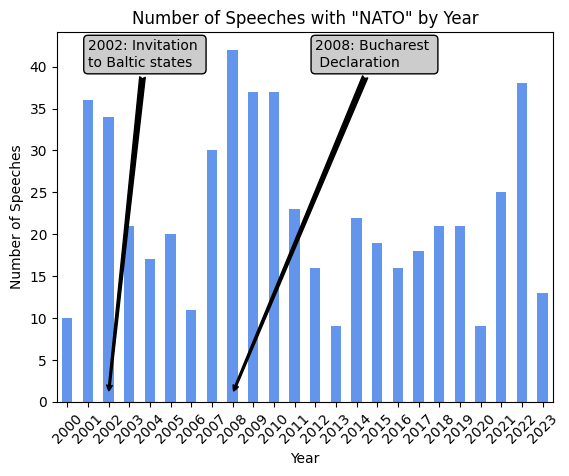

In [33]:
# Plot speeches with "NATO"
speeches_by_year_nato = filtered_nato.groupby(filtered_nato['Year']).size()

# Plotting
speeches_by_year_nato.plot(kind='bar', color='cornflowerblue')
plt.title('Number of Speeches with "NATO" by Year')
plt.xlabel('Year')
plt.ylabel('Number of Speeches')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Annotating the plot to mark specific years
plt.annotate('2002: Invitation \nto Baltic states', xy=(2, 1), xytext=(1, 40),
              bbox=dict(boxstyle="round", fc="0.8"),
             arrowprops=dict(color="black", arrowstyle='fancy'))
plt.annotate('2008: Bucharest \n Declaration', xy=(8, 1), xytext=(12, 40),
              bbox=dict(boxstyle="round", fc="0.8"),
             arrowprops=dict(color="black", arrowstyle='fancy'))

plt.show()


The NATO Bucharest Summit that issued the declaration that Ukraine and Georgia would be members of NATO occurred in April 2008.  Explore the speeches on the Kremlin webpage around that time.

In [34]:
# create dataframe just from January 2007 to December 2010
bucharest_df = filtered_nato[(filtered_nato['date'] >= '2007-01-01') & (filtered_nato['date'] <= '2010-12-31')]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
bucharest_df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Unnamed: 0                date persons                            place  \
1862        1862 2007-01-18 07:26:00      []              The Kremlin, Moscow   
1882        1882 2007-02-01 13:09:00      []  Round Hall, the Kremlin, Moscow   
1888        1888 2007-02-10 01:38:00      []                           Munich   
1890        1890 2007-02-10 20:48:00      []                              NaN   
1913        1913 2007-03-14 20:49:00      []                             Bari   

                                                                                                    title  \
1862             Interview for Indian Television Channel Doordarshan and Press Trust of India News Agency   
1882                                    Transcript of Press Conference with the Russian and Foreign Media   
1888                      Speech and the Following Discussion at the Munich Conference on Security Policy   
1890                                                     Interview with Arab Satellite Channel Al-Jazeera   
1913  Press Statements and Answers to Journalists’ Questions Following Russian-Italian Intergovernment...   

     langs  \
1862    en   
1882    en   
1888    en   
1890    en   
1913    en   

                                                                           transcripts_sentence_tokenized  \
1862  ['Question: Mr President!', 'Our countries’ relations have a long history.', 'In the past, our d...   
1882  ['President Vladimir Putin: Good afternoon, ladies and gentlemen.', 'As has become tradition, I ...   
1888  ['Vladimir Putin: Thank you very much dear Madam Federal Chancellor, Mr Teltschik, ladies and ge...   
1890  ['Comment: Mr President, It gives me pleasure to welcome you to Al-Jazeera.', 'Thank you for fin...   
1913  ['President Vladimir Putin : Dear Mr. Prime Minister!', 'Ladies and gentlemen!', 'First and fore...   

                                                                                        stopwords_removed  \
1862  ['question', 'mr', 'president', 'countries', '’', 'relations', 'long', 'history', 'past', 'dialo...   
1882  ['president', 'vladimir', 'putin', 'good', 'afternoon', 'ladies', 'gentlemen', 'become', 'tradit...   
1888  ['vladimir', 'putin', 'thank', 'much', 'dear', 'madam', 'federal', 'chancellor', 'mr', 'teltschi...   
1890  ['comment', 'mr', 'president', 'gives', 'pleasure', 'welcome', 'al-jazeera', 'thank', 'finding',...   
1913  ['president', 'vladimir', 'putin', 'dear', 'mr.', 'prime', 'minister', 'ladies', 'gentlemen', 'f...   

                                                                                                 pos_tags  \
1862  [('question', 'NN'), ('mr', 'FW'), ('president', 'NN'), ('countries', 'NNS'), ('’', 'VBP'), ('re...   
1882  [('president', 'NN'), ('vladimir', 'NN'), ('putin', 'NN'), ('good', 'JJ'), ('afternoon', 'NN'), ...   
1888  [('vladimir', 'NN'), ('putin', 'NN'), ('thank', 'NN'), ('much', 'JJ'), ('dear', 'IN'), ('madam',...   
1890  [('comment', 'NN'), ('mr', 'NN'), ('president', 'NN'), ('gives', 'VBZ'), ('pleasure', 'JJ'), ('w...   
1913  [('president', 'NN'), ('vladimir', 'NN'), ('putin', 'NN'), ('dear', 'IN'), ('mr.', 'JJ'), ('prim...   

                                                                                              wordnet_pos  \
1862  [('question', 'n'), ('mr', 'n'), ('president', 'n'), ('countries', 'n'), ('’', 'v'), ('relations...   
1882  [('president', 'n'), ('vladimir', 'n'), ('putin', 'n'), ('good', 'a'), ('afternoon', 'n'), ('lad...   
1888  [('vladimir', 'n'), ('putin', 'n'), ('thank', 'n'), ('much', 'a'), ('dear', 'n'), ('madam', 'a')...   
1890  [('comment', 'n'), ('mr', 'n'), ('president', 'n'), ('gives', 'v'), ('pleasure', 'a'), ('welcome...   
1913  [('president', 'n'), ('vladimir', 'n'), ('putin', 'n'), ('dear', 'n'), ('mr.', 'a'), ('prime', '...   

                                                                                               lemmatized  \
1862  ['question', 'mr', 'president', 'country', '

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


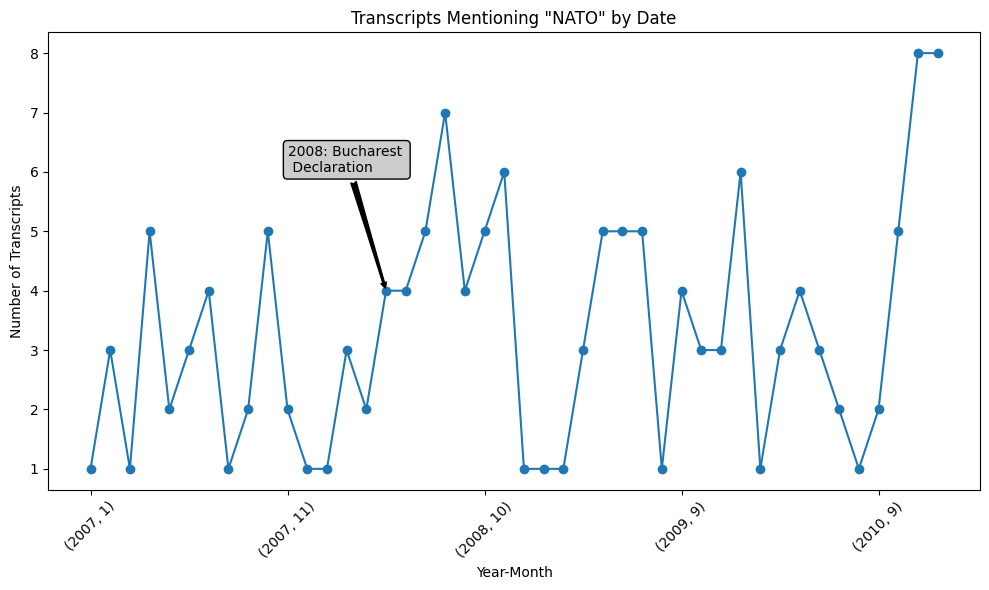

In [36]:
# Plotting the line plot
import pandas as pd
import matplotlib.pyplot as plt



# Group by year and month, then count occurrences
transcripts_by_year_month = bucharest_df.groupby(['Year', 'Month']).size()

# Plotting the line plot
plt.figure(figsize=(10, 6))
transcripts_by_year_month.plot(marker='o', linestyle='-')
plt.title('Transcripts Mentioning "NATO" by Date')
plt.xlabel('Year-Month')
plt.ylabel('Number of Transcripts')
plt.xticks(rotation=45)
plt.tight_layout()

plt.annotate('2008: Bucharest \n Declaration', xy=(15, 4), xytext=(10, 6),
              bbox=dict(boxstyle="round", fc="0.8"),
             arrowprops=dict(color="black", arrowstyle='fancy'))
plt.show()





/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


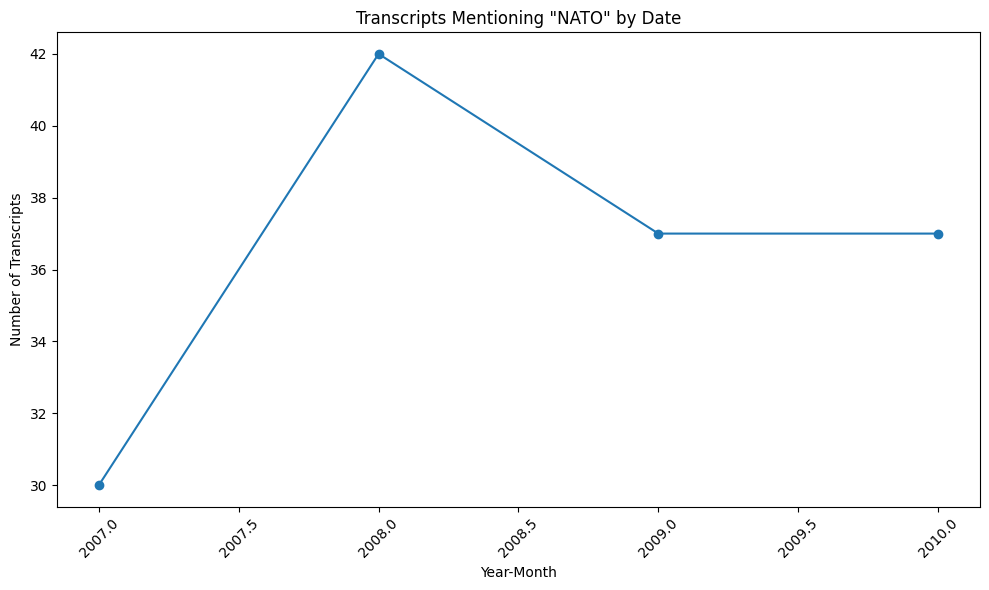

In [37]:
# Group by year, then count occurrences
transcripts_by_year = bucharest_df.groupby(['Year']).size()

# Plotting the line plot
plt.figure(figsize=(10, 6))
transcripts_by_year.plot(marker='o', linestyle='-')
plt.title('Transcripts Mentioning "NATO" by Date')
plt.xlabel('Year-Month')
plt.ylabel('Number of Transcripts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

We see a peak in the mentions of "NATO" around the lead up to the April 2008 Bucharest Summit.

In [38]:
# Save Bucharest DF for separate sentiment analysis

bucharest_df.to_csv('/content/drive/MyDrive/DATA 495/bucharest_df.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
# find transcripts with ukraine

filtered_ukraine = df[df['found_keywords'].apply(lambda x: 'ukraine' in x)]

len(filtered_ukraine)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


970

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


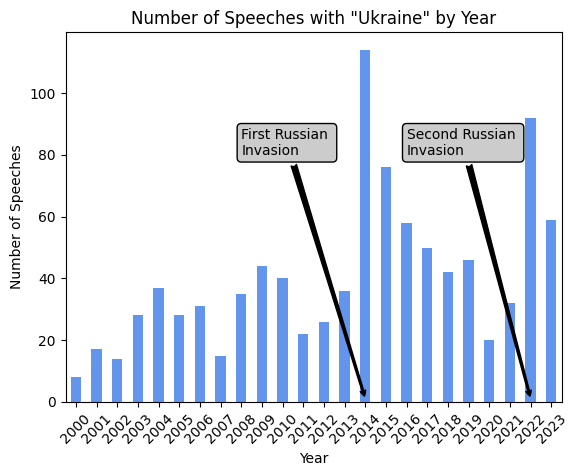

In [40]:
# plot speeches with "Ukraine"

# Group the speeches by year and count occurrences
speeches_by_year_ukraine = filtered_ukraine.groupby(filtered_ukraine['Year']).size()


# Plotting
speeches_by_year_ukraine.plot(kind='bar', color='cornflowerblue')
plt.title('Number of Speeches with "Ukraine" by Year')
plt.xlabel('Year')
plt.ylabel('Number of Speeches')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.annotate('First Russian \nInvasion', xy=(14, 1), xytext=(8, 80),
              bbox=dict(boxstyle="round", fc="0.8"),
             arrowprops=dict(color="black", arrowstyle='fancy'))
plt.annotate('Second Russian \nInvasion', xy=(22, 1), xytext=(16, 80),
              bbox=dict(boxstyle="round", fc="0.8"),
             arrowprops=dict(color="black", arrowstyle='fancy'))

plt.show()


2014 witnessed the end of the Maidan revolution in Ukraine when the Ukrainians threw out their president, Yanukovich, and the Russians annexed Crimea and invaded the Donbass.

2022 saw Russia large a full scale invasion of Ukraine.

In [41]:
# create dataframe just from January 2014 to December 2014
maidan_df = filtered_ukraine[(filtered_ukraine['date'] >= '2014-01-01') & (filtered_ukraine['date'] <= '2014-12-31')]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
# subset df of all speeches for this date too
all_2014_df = df[(df['date'] >= '2014-01-01') & (df['date'] <= '2014-12-31')]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
# group by month
maidan_by_month = maidan_df.groupby(['Year', 'Month']).size()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [44]:
# group by month
all_2014_df_by_month = all_2014_df.groupby(['Year', 'Month']).size()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


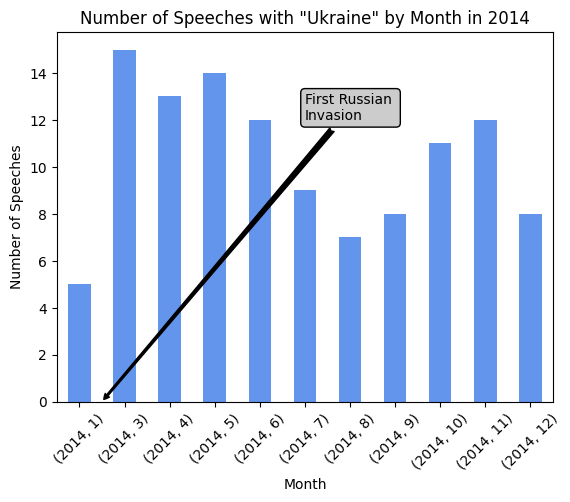

In [45]:
# Plotting bar chart
fig, ax1 = plt.subplots()

# Creating the bar chart
maidan_by_month.plot(kind='bar', color='cornflowerblue', ax=ax1)
ax1.set_title('Number of Speeches with "Ukraine" by Month in 2014')
ax1.set_xlabel('Month')
ax1.set_ylabel('Number of Speeches')
ax1.tick_params(axis='x', rotation=45)

plt.annotate('First Russian \nInvasion', xy=(.5, 0), xytext=(5, 12),
              bbox=dict(boxstyle="round", fc="0.8"),
             arrowprops=dict(color="black", arrowstyle='fancy'))
plt.show()


There were no speeches mentioning Ukraine in February 2014. The Ukrainian Maidan revolution ended in February 2014 and Russian troops invaded Crimea on February 20.  It is very curious that there was silence on Ukraine that month and then a peak in March.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


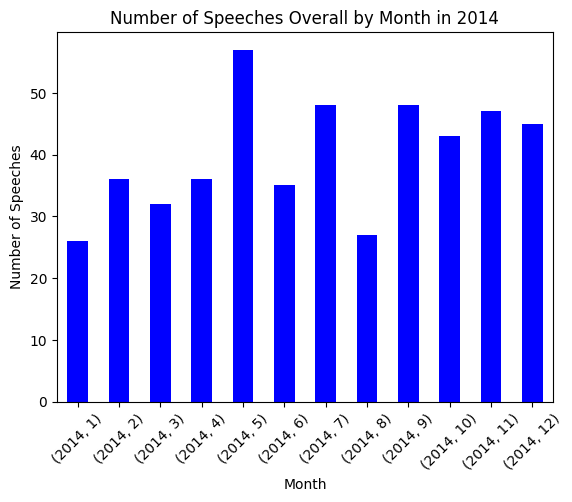

In [46]:
# Plotting bar chart
fig, ax1 = plt.subplots()

# Creating the bar chart
all_2014_df_by_month.plot(kind='bar', color='blue', ax=ax1)
ax1.set_title('Number of Speeches Overall by Month in 2014')
ax1.set_xlabel('Month')
ax1.set_ylabel('Number of Speeches')
ax1.tick_params(axis='x', rotation=45)



plt.show()


In [47]:
# save ukraine dataset

filtered_ukraine.to_csv("/content/drive/MyDrive/DATA 495/ukraine_df.csv")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [48]:
# Find rows with "crimea"



filtered_crimea = filtered_df[filtered_df['stopwords_removed'].apply(lambda x: 'crimea' in x)]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [49]:
filtered_crimea.info()

<class 'pandas.core.frame.DataFrame'>
Index: 437 entries, 305 to 9620
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Unnamed: 0                      437 non-null    int64         
 1   date                            437 non-null    datetime64[ns]
 2   persons                         437 non-null    object        
 3   place                           403 non-null    object        
 4   title                           437 non-null    object        
 5   langs                           437 non-null    object        
 6   transcripts_sentence_tokenized  437 non-null    object        
 7   stopwords_removed               437 non-null    object        
 8   pos_tags                        437 non-null    object        
 9   wordnet_pos                     437 non-null    object        
 10  lemmatized                      437 non-null    object        
 11  word_cou

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


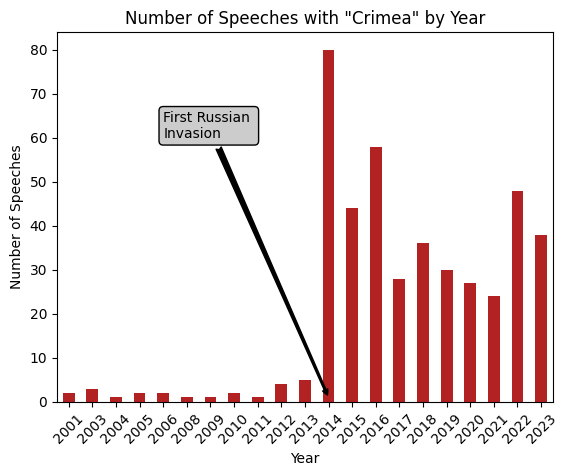

In [50]:
# plot speeches with "Crimea"

# Group the speeches by year and count occurrences
speeches_by_year_crimea = filtered_crimea.groupby(filtered_crimea['Year']).size()


# Plotting
speeches_by_year_crimea.plot(kind='bar', color='firebrick')
plt.title('Number of Speeches with "Crimea" by Year')
plt.xlabel('Year')
plt.ylabel('Number of Speeches')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.annotate('First Russian \nInvasion', xy=(11, 1), xytext=(4, 60),
              bbox=dict(boxstyle="round", fc="0.8"),
             arrowprops=dict(color="black", arrowstyle='fancy'))


plt.show()


In [51]:
# Save crimea dataset

filtered_crimea.to_csv("/content/drive/MyDrive/DATA 495/crimea_df.csv")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [59]:
# Define the keywords related to China
china_keywords = ["china", "chinese", "xi", "jiang", "prc"]





/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1162

In [60]:
# Filter transcripts that contain any of the China-related keywords
filtered_china = filtered_df[filtered_df['stopwords_removed'].apply(lambda x: any(keyword in x for keyword in china_keywords))]

len(filtered_china)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2629

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


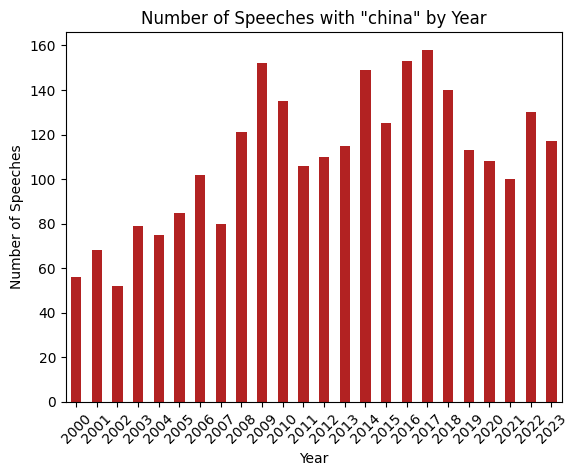

In [61]:
# plot speeches with "china"

# Group the speeches by year and count occurrences
speeches_by_year_china = filtered_china.groupby(filtered_china['Year']).size()


# Plotting
speeches_by_year_china.plot(kind='bar', color='firebrick')
plt.title('Number of Speeches with "china" by Year')
plt.xlabel('Year')
plt.ylabel('Number of Speeches')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability




plt.show()


In [62]:
# Save china dataset

filtered_china.to_csv("/content/drive/MyDrive/DATA 495/china_df.csv")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Term Frequency Analysis

In [64]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a CountVectorizer
tf_vectorizer = CountVectorizer()

# Fit and transform the "stopwords_removed" column to get the TF matrix
tf_matrix = tf_vectorizer.fit_transform(df['stopwords_removed'])

# Print the shape of the TF matrix
print(tf_matrix.shape)

# Print the words in the vocabulary
print(tf_vectorizer.vocabulary_)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(9623, 51841)
{'vladimir': 49669, 'putin': 36469, 'dear': 12078, 'friends': 18165, 'new': 31093, 'year': 51046, 'eve': 16058, 'family': 16782, 'planned': 34586, 'gather': 18629, 'round': 39413, 'tv': 47459, 'probably': 35786, 'listen': 26956, 'address': 2260, 'president': 35566, 'boris': 7051, 'yeltsin': 51107, 'things': 45968, 'took': 46446, 'different': 13181, 'turn': 47419, 'december': 12149, '31': 858, '1999': 546, 'russia': 39645, 'first': 17398, 'decided': 12170, 'resign': 38455, 'asked': 4546, 'russian': 39647, 'people': 33852, 'today': 46323, 'powers': 35260, 'head': 20473, 'state': 43583, 'turned': 47424, 'presidential': 35567, 'election': 14955, 'held': 20623, 'three': 46039, 'months': 29879, 'assure': 4673, 'vacuum': 48904, 'power': 35248, 'minute': 29399, 'promise': 35984, 'attempts': 4824, 'act': 2180, 'contrary': 10828, 'law': 26292, 'constitution': 10670, 'cut': 11715, 'short': 41656, 'stand': 43494, 'firm': 17391, 'protect': 36143, 'freedom': 18085, 'speech': 43145, 'co

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the "stopwords_removed" column to get the TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(df['stopwords_removed'])

# Print the shape of the TF-IDF matrix
print(tfidf_matrix.shape)

# Print the words in the vocabulary
print(tfidf_vectorizer.vocabulary_)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(9623, 51841)
{'vladimir': 49669, 'putin': 36469, 'dear': 12078, 'friends': 18165, 'new': 31093, 'year': 51046, 'eve': 16058, 'family': 16782, 'planned': 34586, 'gather': 18629, 'round': 39413, 'tv': 47459, 'probably': 35786, 'listen': 26956, 'address': 2260, 'president': 35566, 'boris': 7051, 'yeltsin': 51107, 'things': 45968, 'took': 46446, 'different': 13181, 'turn': 47419, 'december': 12149, '31': 858, '1999': 546, 'russia': 39645, 'first': 17398, 'decided': 12170, 'resign': 38455, 'asked': 4546, 'russian': 39647, 'people': 33852, 'today': 46323, 'powers': 35260, 'head': 20473, 'state': 43583, 'turned': 47424, 'presidential': 35567, 'election': 14955, 'held': 20623, 'three': 46039, 'months': 29879, 'assure': 4673, 'vacuum': 48904, 'power': 35248, 'minute': 29399, 'promise': 35984, 'attempts': 4824, 'act': 2180, 'contrary': 10828, 'law': 26292, 'constitution': 10670, 'cut': 11715, 'short': 41656, 'stand': 43494, 'firm': 17391, 'protect': 36143, 'freedom': 18085, 'speech': 43145, 'co

In [66]:
# Calculate the sum of TF-IDF scores for each term across all documents

term_importance = tfidf_matrix.sum(axis=0)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [67]:
# Sort the terms based on their importance scores and extract the most important ones


# Get the feature names (terms) from the vectorizer
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

# Get the indices of the terms sorted by importance
sorted_term_indices = term_importance.argsort()[0]

# Extract the most important terms (adjust the number as needed)
num_top_terms = 10
most_important_terms = feature_names[sorted_term_indices[-num_top_terms:]]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [68]:
most_important_terms

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([['odours', 'subtopics', 'billed', ..., 'would', 'russian',
        'russia']], dtype=object)

In [69]:
from nltk import downloader

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [70]:
nltk.download('stopwords')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [71]:
stop = set(nltk.corpus.stopwords.words('english'))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [72]:
# create corpus for word level analysis




corpus=[]
new= df['stopwords_removed'].str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
   if word in stop:
        dic[word]+=1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: >

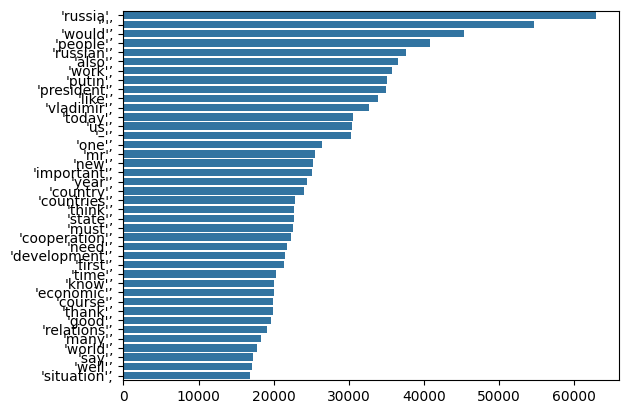

In [73]:
counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)

In [74]:
import numpy as np

# Sample data, assuming most_important_terms is structured similarly
most_important_terms = [np.array(['specific', 'nadeshda', 'okolnaya', 'would', 'russian', 'russia'], dtype=object)]

# Extract the NumPy array from the list (assuming it's the first element)
terms_array = most_important_terms[0]

# Iterate and print the terms
for term in terms_array:
    print(term)


specific
nadeshda
okolnaya
would
russian
russia


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### N-Gram Analysis


In [75]:
from nltk.util import ngrams

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [76]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [83]:
import seaborn as sns



def plot_top_ngrams_barchart(text, n=2):
    stop = set(nltk.corpus.stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx])
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)
    plt.title('Top ' + str(n) + '-grams Bar Chart')  # Set a title for the plot

    plt.show()




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


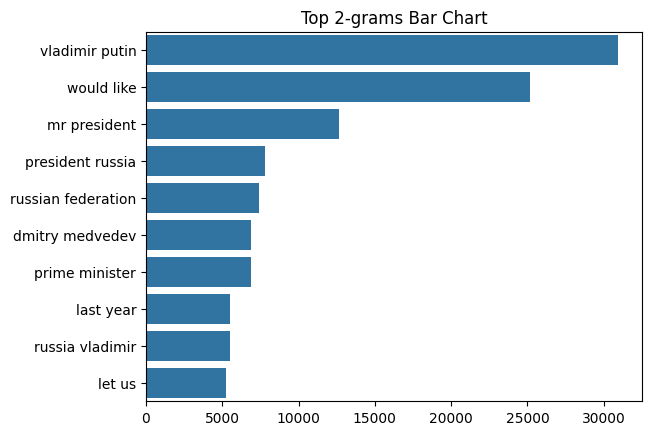

In [84]:
plot_top_ngrams_barchart(df['stopwords_removed'],2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


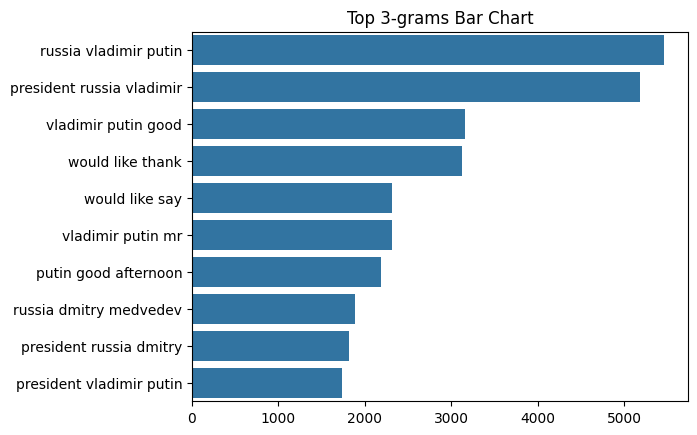

In [85]:
plot_top_ngrams_barchart(df['stopwords_removed'],3)

In [86]:
# remove personal names from df and see what top n-grams are
# source:  chatGPT

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk import word_tokenize, pos_tag


# Function to filter out proper nouns and additional words
def filter_words(text):
    words = word_tokenize(text)
    tags = pos_tag(words)
    filtered_words = [word for word, tag in tags if tag != 'NNP' and tag!= 'NNPS']  # Replace 'word1', 'word2', etc. with your additional words to exclude
    return ' '.join(filtered_words)

# Apply the function to create a new column with filtered words
df['filtered_words'] = df['stopwords_removed'].apply(filter_words)




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


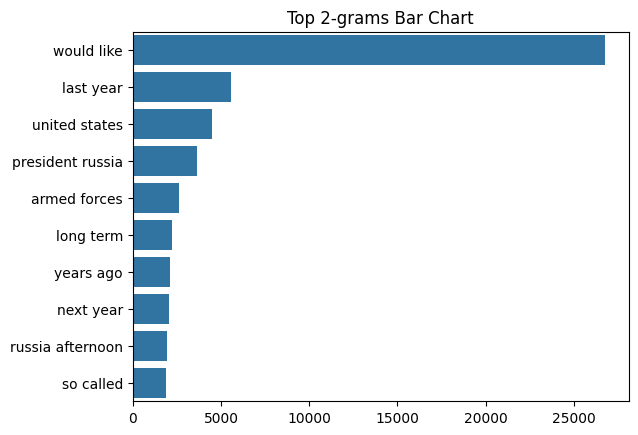

In [87]:
# now plot the filtered n_grams
plot_top_ngrams_barchart(df['filtered_words'],2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


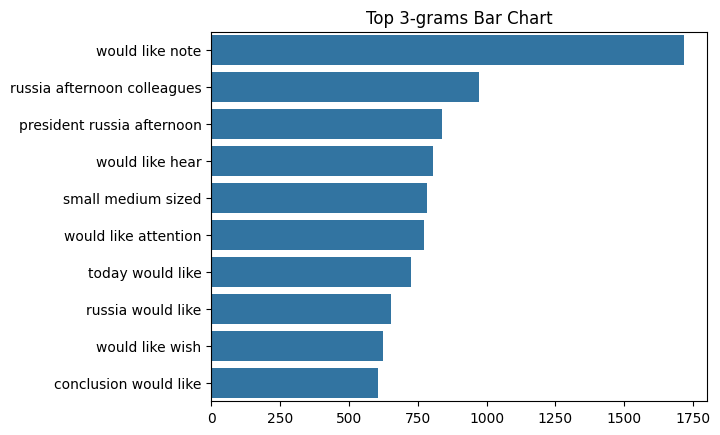

In [88]:
plot_top_ngrams_barchart(df['filtered_words'],3)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


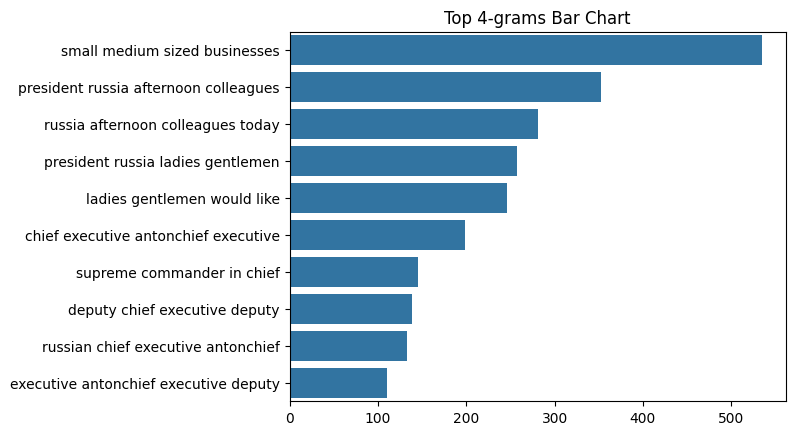

In [89]:
plot_top_ngrams_barchart(df['filtered_words'],4)

### Topic Modeling

Topic modeling using the code and instructions in this tutorial:
https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools


In [90]:
# Ensure text is preprocessed correctly
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Unnamed: 0                date persons                         place  \
0           0 1999-12-31 00:01:00      []           The Kremlin, Moscow   
1           1 1999-12-31 00:02:00      []           The Kremlin, Moscow   
2           2 1999-12-31 00:03:00      []           The Kremlin, Moscow   
3           3 2000-01-04 00:00:00      []                        Moscow   
4           4 2000-01-11 00:00:00      []  State Kremlin Palace, Moscow   

                                                                     title  \
0                      New Year Address by Acting President Vladimir Putin   
1           Address at an expanded meeting of the Russian Security Council   
2                                               Statement by Boris Yeltsin   
3                                        Interview with the ORT TV Channel   
4  Speech at gala function marking the second millennium of Christ’s birth   

  langs  \
0    en   
1    en   
2    en   
3    en   
4    en   

                                                                        transcripts_sentence_tokenized  \
0  ['Vladimir Putin: Dear friends, On New Year’s Eve, my family and I planned to gather round the T...   
1  ['Vladimir Putin: Good afternoon, distinguished colleagues.', 'This will be a short meeting.', '...   
2  ['Boris Yeltsin: Dear Russians, In a few hours we will see a magical date on our calendars, the ...   
3  ['Question: Mr Putin, the sudden resignation of Mr Yeltsin has prompted many questions in this c...   
4  ['Vladimir Putin: Dear friends, We are again gathered here today, this time on the occasion of t...   

                                                                                     stopwords_removed  \
0  ['vladimir', 'putin', 'dear', 'friends', 'new', 'year', '’', 'eve', 'family', 'planned', 'gather...   
1  ['vladimir', 'putin', 'good', 'afternoon', 'distinguished', 'colleagues', 'short', 'meeting', 'a...   
2  ['boris', 'yeltsin', 'dear', 'russians', 'hours', 'see', 'magical', 'date', 'calendars', 'year',...   
3  ['question', 'mr', 'putin', 'sudden', 'resignation', 'mr', 'yeltsin', 'prompted', 'many', 'quest...   
4  ['vladimir', 'putin', 'dear', 'friends', 'gathered', 'today', 'time', 'occasion', 'joyful', 'cel...   

                                                                                              pos_tags  \
0  [('vladimir', 'NN'), ('putin', 'NN'), ('dear', 'JJ'), ('friends', 'NNS'), ('new', 'JJ'), ('year'...   
1  [('vladimir', 'NN'), ('putin', 'NN'), ('good', 'JJ'), ('afternoon', 'NN'), ('distinguished', 'VB...   
2  [('boris', 'NN'), ('yeltsin', 'NN'), ('dear', 'JJ'), ('russians', 'NNS'), ('hours', 'NNS'), ('se...   
3  [('question', 'NN'), ('mr', 'NN'), ('putin', 'NN'), ('sudden', 'JJ'), ('resignation', 'NN'), ('m...   
4  [('vladimir', 'NN'), ('putin', 'NN'), ('dear', 'JJ'), ('friends', 'NNS'), ('gathered', 'VBN'), (...   

                                                                                           wordnet_pos  \
0  [('vladimir', 'n'), ('putin', 'n'), ('dear', 'a'), ('friends', 'n'), ('new', 'a'), ('year', 'n')...   
1  [('vladimir', 'n'), ('putin', 'n'), ('good', 'a'), ('afternoon', 'n'), ('distinguished', 'v'), (...   
2  [('boris', 'n'), ('yeltsin', 'n'), ('dear', 'a'), ('russians', 'n'), ('hours', 'n'), ('see', 'v'...   
3  [('question', 'n'), ('mr', 'n'), ('putin', 'n'), ('sudden', 'a'), ('resignation', 'n'), ('mr', '...   
4  [('vladimir', 'n'), ('putin', 'n'), ('dear', 'a'), ('friends', 'n'), ('gathered', 'v'), ('today'...   

                                                                                            lemmatized  \
0  ['vladimir', 'putin', 'dear', 'friend', 'new', 'year', '’', 'eve', 'family', 'plan', 'gather', '...   
1  ['vladimir', 'putin', 'good', 'afternoon', 'distinguish', 'colleague', 'short', 'meeting', 'ask'...   
2  ['boris', 'yeltsin', 'dear', 'russian', 'hour', 'see', 'magical', 'date', 'calendar', 'year', '2...   
3  ['question', 'mr', 'putin', 'sudden', 're

In [91]:
# transcripts are not lemmatized, so do that now

import nltk
nltk.download('punkt')
nltk.download('wordnet')

from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

def preprocess_transcripts(df):
    corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for transcript in df['stopwords_removed']:
        words=[w for w in word_tokenize(transcript) if (w not in stop)]

        words=[lem.lemmatize(w) for w in words if len(w)>2]

        corpus.append(words)
    return corpus

corpus=preprocess_transcripts(df)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [92]:
# create bag of words model using gensim
import gensim

dic=gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LDA allows us to see what the most prevalent topics there are in the transcripts and which transcripts relate to those topics.

In [93]:
# create LDA model



lda_model = gensim.models.LdaMulticore(bow_corpus,
                                   num_topics = 4,
                                   id2word = dic,
                                   passes = 10,
                                   workers = 2)
lda_model.show_topics()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.015*"\'russia" + 0.010*"\'cooperation" + 0.010*"\'president" + 0.008*"\'relations" + 0.008*"\'countries" + 0.007*"\'russian" + 0.007*"\'would" + 0.007*"\'also" + 0.006*"\'economic" + 0.006*"\'today"'),
 (1,
  '0.006*"\'would" + 0.006*"\'work" + 0.006*"\'people" + 0.006*"\'vladimir" + 0.005*"\'also" + 0.005*"\'putin" + 0.005*"\'year" + 0.005*"\'need" + 0.005*"\'like" + 0.005*"\'must"'),
 (2,
  '0.011*"\'people" + 0.010*"\'russia" + 0.007*"\'would" + 0.006*"\'country" + 0.006*"\'us" + 0.005*"\'think" + 0.005*"\'one" + 0.005*"\'russian" + 0.005*"\'state" + 0.005*"\'putin"'),
 (3,
  '0.008*"\'russia" + 0.007*"\'vladimir" + 0.006*"\'work" + 0.006*"\'putin" + 0.006*"\'russian" + 0.006*"\'new" + 0.005*"\'today" + 0.005*"\'president" + 0.005*"\'also" + 0.005*"\'military"')]

In [94]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.041387 -0.033448       1        1  32.629601
0      0.072083  0.061046       2        1  28.141748
2      0.054218 -0.058420       3        1  26.600879
3     -0.084914  0.030822       4        1  12.627771, topic_info=             Term          Freq         Total Category  logprob  loglift
176  'cooperation  21921.000000  21921.000000  Default  30.0000  30.0000
295    'relations  18884.000000  18884.000000  Default  29.0000  29.0000
103       'russia  62752.000000  62752.000000  Default  28.0000  28.0000
256     'military   8564.000000   8564.000000  Default  27.0000  27.0000
177    'countries  22674.000000  22674.000000  Default  26.0000  26.0000
..            ...           ...           ...      ...      ...      ...
346        'world   2653.646679  17836.573419   Topic4  -5.7899   0.1640
187  'development   2705.773708  21230.960785   Topic4  -5.7704   0.0092
407    'important   2717.522966  24966.245721   Topic4  -5.7661  -0.1485
438          'one   2484.601401  26524.218232   Topic4  -5.8557  -0.2987
491        'years   2417.664772  16848.309658   Topic4  -5.8830   0.1278

[467 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
19789      2  0.982056       'abdel
19789      3  0.014658       'abdel
8104       2  0.984922  'abishevich
9174       1  0.014373     'african
9174       2  0.955010     'african
...      ...       ...          ...
45663      1  0.984004     'yuryeva
32770      2  0.021772     'zakaria
32770      3  0.979750     'zakaria
12981      2  0.981296          g-8
12981      3  0.011682          g-8

[1210 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 4])

On the left side, the area of each circle represents the importance of the topic relative to the corpus. As there are four topics, we have four circles.

The distance between the center of the circles indicates the similarity between the topics.

On the right side, the histogram of each topic shows the top 30 relevant words.


Source:  https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools


#### Topic Modeling:  More Focused Datasets

Now we can do this with NATO, Ukraine, and Crimea.

In [95]:
# create a NATO corpus
corpus_nato=preprocess_transcripts(filtered_nato)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [96]:
# create bag of words model using gensim

dic_nato=gensim.corpora.Dictionary(corpus_nato)
bow_corpus_nato = [dic_nato.doc2bow(doc) for doc in corpus_nato]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [97]:
# create LDA model

lda_model_nato = gensim.models.LdaMulticore(bow_corpus_nato,
                                   num_topics = 4,
                                   id2word = dic,
                                   passes = 10,
                                   workers = 2)
lda_model_nato.show_topics()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.013*"\'moscow" + 0.007*"\'christmas" + 0.006*"\'extent" + 0.006*"\'discussed" + 0.005*"\'mothers" + 0.005*"\'elements" + 0.005*"\'high-sounding" + 0.005*"\'works" + 0.005*"\'solve" + 0.005*"\'east"'),
 (1,
  '0.009*"\'moscow" + 0.008*"\'courageous" + 0.008*"\'generally" + 0.007*"\'christmas" + 0.007*"\'wife" + 0.007*"\'trust" + 0.006*"\'extent" + 0.005*"\'solve" + 0.005*"\'glass" + 0.005*"\'mothers"'),
 (2,
  '0.008*"\'moscow" + 0.006*"\'christmas" + 0.005*"\'trust" + 0.005*"\'seats" + 0.005*"\'courageous" + 0.004*"\'extent" + 0.004*"\'discussed" + 0.004*"\'generally" + 0.004*"\'elements" + 0.004*"\'solve"'),
 (3,
  '0.009*"\'courageous" + 0.007*"\'wife" + 0.006*"\'generally" + 0.005*"\'trust" + 0.005*"\'moscow" + 0.005*"\'career" + 0.004*"\'christmas" + 0.004*"\'attend" + 0.004*"\'glass" + 0.004*"\'clergymen"')]

In [98]:
# visualize

pyLDAvis.enable_notebook()
vis_nato = pyLDAvis.gensim.prepare(lda_model_nato, bow_corpus_nato, dic)
vis_nato

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.042731 -0.032012       1        1  41.477602
1     -0.006674 -0.008170       2        1  35.384045
3     -0.065245 -0.001488       3        1  16.932601
2      0.029189  0.041669       4        1   6.205752, topic_info=            Term          Freq         Total Category  logprob  loglift
583  'courageous   8153.000000   8153.000000  Default  30.0000  30.0000
699      'moscow  13264.000000  13264.000000  Default  29.0000  29.0000
882        'wife   6319.000000   6319.000000  Default  28.0000  28.0000
864       'trust   7359.000000   7359.000000  Default  27.0000  27.0000
638   'generally   6946.000000   6946.000000  Default  26.0000  26.0000
..           ...           ...           ...      ...      ...      ...
529      'attend    216.616317   4016.166813   Topic4  -5.9426  -0.1403
817       'speak    215.645225   4077.257953   Topic4  -5.9471  -0.1599
192   'documents    207.468426   3894.287426   Topic4  -5.9857  -0.1526
541     'beijing    209.035331   4264.496803   Topic4  -5.9782  -0.2359
639       'glass    213.995037   5800.530013   Topic4  -5.9548  -0.5201

[392 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
23586      4  0.870762    '-although
6917       1  0.079593  '109,372,000
6917       2  0.427812  '109,372,000
6917       3  0.029847  '109,372,000
6917       4  0.457659  '109,372,000
...      ...       ...           ...
13103      4  0.894512           4–6
23570      1  0.008845          7–22
23570      2  0.972938          7–22
23570      3  0.008845          7–22
23570      4  0.008845          7–22

[826 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3])

Repeat with Ukraine


In [99]:
# create a Ukraine corpus
corpus_ukraine=preprocess_transcripts(filtered_ukraine)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [100]:
# create bag of words model using gensim

dic_ukraine=gensim.corpora.Dictionary(corpus_ukraine)
bow_corpus_ukraine = [dic_ukraine.doc2bow(doc) for doc in corpus_ukraine]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [101]:
# create LDA model

lda_model_ukraine = gensim.models.LdaMulticore(bow_corpus_ukraine,
                                   num_topics = 4,
                                   id2word = dic,
                                   passes = 10,
                                   workers = 2)
lda_model_ukraine.show_topics()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.010*"\'steps" + 0.007*"\'drank" + 0.006*"\'commands" + 0.006*"\'failures" + 0.006*"\'religions" + 0.006*"\'still" + 0.005*"\'charged" + 0.005*"\'naive" + 0.005*"\'took" + 0.005*"\'conversation"'),
 (1,
  '0.011*"\'steps" + 0.007*"\'drank" + 0.006*"\'religions" + 0.006*"\'belongs" + 0.005*"\'democracy" + 0.005*"\'still" + 0.005*"\'commands" + 0.005*"\'naive" + 0.005*"\'nearly" + 0.005*"\'60"'),
 (2,
  '0.009*"\'failures" + 0.009*"\'conversation" + 0.008*"\'naive" + 0.006*"\'drank" + 0.006*"\'commands" + 0.005*"\'nearly" + 0.005*"\'date" + 0.005*"\'fair" + 0.005*"\'signed" + 0.004*"\'steps"'),
 (3,
  '0.010*"\'failures" + 0.007*"\'still" + 0.006*"\'steps" + 0.005*"\'conversation" + 0.005*"\'drank" + 0.005*"\'naive" + 0.005*"\'signed" + 0.004*"\'besides" + 0.004*"\'demonstrate" + 0.004*"\'belong"')]

In [102]:
# visualize

pyLDAvis.enable_notebook()
vis_ukraine = pyLDAvis.gensim.prepare(lda_model_ukraine, bow_corpus_ukraine, dic)
vis_ukraine

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.044991  0.024106       1        1  34.502570
0      0.032232  0.018905       2        1  29.979320
2      0.013450 -0.053722       3        1  29.846826
3     -0.090673  0.010712       4        1   5.671284, topic_info=               Term          Freq         Total Category  logprob  loglift
392       'failures  11972.000000  11972.000000  Default  30.0000  30.0000
467          'still   8922.000000   8922.000000  Default  29.0000  29.0000
466          'steps  15935.000000  15935.000000  Default  28.0000  28.0000
580   'conversation  10794.000000  10794.000000  Default  27.0000  27.0000
3418       'besides   1732.000000   1732.000000  Default  26.0000  26.0000
...             ...           ...           ...      ...      ...      ...
295      'relations    294.546320   6609.860631   Topic4  -5.8813  -0.2411
508         'agreed    266.198758   4926.111338   Topic4  -5.9825  -0.0483
123           'true    257.114576   5426.187208   Topic4  -6.0172  -0.1797
385          'enter    237.580925   3598.631933   Topic4  -6.0962   0.1520
357       'believed    247.288303   5641.962148   Topic4  -6.0562  -0.2577

[414 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
33890      2  0.050429       '+10
33890      4  0.907722       '+10
29317      1  0.012591      '1650
29317      2  0.956900      '1650
29317      4  0.037772      '1650
...      ...       ...        ...
20319      1  0.023140      3,400
20319      3  0.971876      3,400
7052       1  0.950621  v.strygin
7052       2  0.027161  v.strygin
7052       3  0.027161  v.strygin

[968 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 4])

#### Repeat with Crimea

In [103]:
# create a Crimea corpus
corpus_crimea=preprocess_transcripts(filtered_crimea)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [104]:
# create bag of words model using gensim

dic_crimea=gensim.corpora.Dictionary(corpus_crimea)
bow_corpus_crimea = [dic_crimea.doc2bow(doc) for doc in corpus_crimea]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [105]:
# create LDA model

lda_model_crimea = gensim.models.LdaMulticore(bow_corpus_crimea,
                                   num_topics = 4,
                                   id2word = dic,
                                   passes = 10,
                                   workers = 2)
lda_model_crimea.show_topics()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.008*"\'usual" + 0.008*"\'documents" + 0.008*"\'arbitration" + 0.006*"\'ensure" + 0.005*"\'putin" + 0.005*"\'model" + 0.005*"\'invited" + 0.004*"\'mood" + 0.004*"\'clergy" + 0.004*"\'whereas"'),
 (1,
  '0.005*"\'authority" + 0.005*"\'ensure" + 0.005*"\'root" + 0.005*"\'interview" + 0.004*"\'weather" + 0.004*"\'putin" + 0.004*"\'mood" + 0.004*"\'attending" + 0.004*"\'2000" + 0.003*"\'shield"'),
 (2,
  '0.007*"\'documents" + 0.007*"\'arbitration" + 0.006*"\'weather" + 0.006*"\'latest" + 0.005*"\'ensure" + 0.005*"\'2000" + 0.005*"\'maxim" + 0.005*"\'model" + 0.005*"\'decision" + 0.005*"\'attending"'),
 (3,
  '0.009*"\'attending" + 0.008*"\'usual" + 0.007*"\'ensure" + 0.007*"\'invited" + 0.006*"\'arbitration" + 0.005*"\'documents" + 0.005*"\'2000" + 0.005*"\'authority" + 0.005*"\'putin" + 0.004*"\'clergy"')]

In [106]:
# visualize

pyLDAvis.enable_notebook()
vis_crimea = pyLDAvis.gensim.prepare(lda_model_crimea, bow_corpus_crimea, dic)
vis_crimea

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.069812 -0.028071       1        1  56.258368
0     -0.020104 -0.002266       2        1  26.303107
2      0.000268  0.052864       3        1  14.211370
1      0.089647 -0.022526       4        1   3.227155, topic_info=              Term         Freq        Total Category  logprob  loglift
153     'authority  4619.000000  4619.000000  Default  30.0000  30.0000
200        'ensure  6362.000000  6362.000000  Default  29.0000  29.0000
876       'weather  4165.000000  4165.000000  Default  28.0000  28.0000
96          'putin  4830.000000  4830.000000  Default  27.0000  27.0000
258          'mood  4303.000000  4303.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
181       'defence    81.740101  3121.859603   Topic4  -6.0158  -0.2091
1325      'invited    86.606205  5695.698293   Topic4  -5.9580  -0.7525
192     'documents    81.704179  6474.662361   Topic4  -6.0163  -0.9390
1386       'mozdok    74.033969  2437.514291   Topic4  -6.1149  -0.0606
144   'arbitration    78.353867  6675.274291   Topic4  -6.0582  -1.0114

[399 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
20715      1  0.042226          '115
20715      2  0.928972          '115
22957      4  0.725153         '15.1
17128      1  0.975108        '1870s
24602      3  0.970080          '195
...      ...       ...           ...
27260      4  0.782255       '−34–35
22914      1  0.148568  l.tolmacheva
22914      2  0.148568  l.tolmacheva
22914      4  0.705699  l.tolmacheva
21069      2  0.963492      p.pautov

[876 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 2])

In [107]:
# create a china corpus
corpus_china=preprocess_transcripts(filtered_china)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [108]:
# create bag of words model using gensim

dic_china=gensim.corpora.Dictionary(corpus_china)
bow_corpus_china = [dic_china.doc2bow(doc) for doc in corpus_china]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [109]:
# create LDA model

lda_model_china = gensim.models.LdaMulticore(bow_corpus_china,
                                   num_topics = 4,
                                   id2word = dic,
                                   passes = 10,
                                   workers = 2)
lda_model_china.show_topics()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.008*"\'third" + 0.008*"\'half" + 0.007*"\'beijing" + 0.006*"\'unique" + 0.005*"\'services" + 0.005*"\'airport" + 0.005*"\'society" + 0.005*"\'pondered" + 0.005*"\'ambition" + 0.005*"\'cover"'),
 (1,
  '0.009*"\'third" + 0.008*"\'ambition" + 0.008*"\'country" + 0.006*"\'beijing" + 0.005*"\'mood" + 0.005*"\'airport" + 0.005*"\'half" + 0.005*"\'previous" + 0.004*"\'bear" + 0.004*"\'course"'),
 (2,
  '0.014*"\'half" + 0.009*"\'agonised" + 0.008*"\'leaking" + 0.007*"\'smile" + 0.007*"\'beijing" + 0.006*"\'accurate" + 0.006*"\'heard" + 0.006*"\'course" + 0.005*"\'shield" + 0.005*"\'airport"'),
 (3,
  '0.006*"\'best" + 0.006*"\'half" + 0.006*"\'beijing" + 0.005*"\'bear" + 0.005*"\'course" + 0.005*"\'design" + 0.005*"\'heard" + 0.005*"\'mess" + 0.005*"\'ambition" + 0.005*"\'country"')]

In [111]:
# visualize

pyLDAvis.enable_notebook()
vis_china = pyLDAvis.gensim.prepare(lda_model_china, bow_corpus_china, dic)
vis_china

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.073893 -0.010909       1        1  31.309464
0      0.008493  0.018079       2        1  26.471850
3     -0.045115 -0.049118       3        1  21.839876
1     -0.037271  0.041948       4        1  20.378810, topic_info=            Term          Freq         Total Category  logprob  loglift
1343    'leaking  11693.000000  11693.000000  Default  30.0000  30.0000
1059   'accurate   9618.000000   9618.000000  Default  29.0000  29.0000
329       'third  22736.000000  22736.000000  Default  28.0000  28.0000
2899     'design   7478.000000   7478.000000  Default  27.0000  27.0000
514    'ambition  18562.000000  18562.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
487        'wait   2240.750853  11310.692923   Topic4  -5.8628  -0.0283
488         'way   2422.747066  14090.328716   Topic4  -5.7847  -0.1699
448    'pondered   2202.551230  12115.276848   Topic4  -5.8800  -0.1142
297   'remaining   2241.967057  13261.572411   Topic4  -5.8623  -0.1868
544        'best   2204.173693  12638.721597   Topic4  -5.8793  -0.1557

[453 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
14214      1  0.973374  '100–110
14214      2  0.017077  '100–110
14214      4  0.017077  '100–110
16284      1  0.940555     '11.6
16284      2  0.008682     '11.6
...      ...       ...       ...
8989       1  0.961028      7:00
8989       2  0.027458      7:00
48522      1  0.030616     9,600
48522      2  0.030616     9,600
48522      3  0.949108     9,600

[1208 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 4, 2])

### Basic Sentiment Analysis


In [ ]:
from textblob import TextBlob

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Sentiment(polarity=-0.2, subjectivity=0.0)

In [ ]:
# calculate an plot polarity score:  -1 = negative, +1 = positive
from textblob import TextBlob

def calculate_polarity(df, column_name):
    def polarity(text):
        return TextBlob(text).sentiment.polarity

    df['polarity_score'] = df[column_name].apply(polarity)
    df['polarity_score'].hist()

    return df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


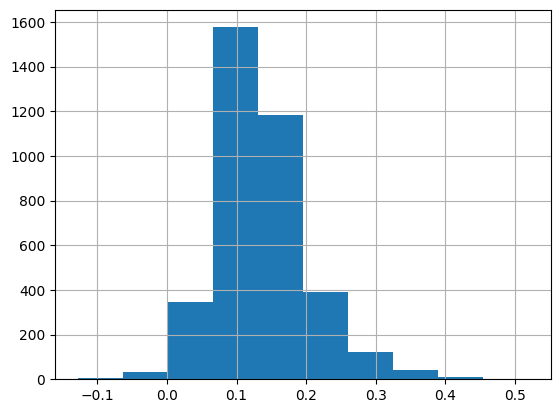

In [ ]:
calculate_polarity(filtered_df, 'stopwords_removed')

In [ ]:
# classify as negative, positive, or neutral based on polarity score

def classify_sentiment(df, score_column):
    def sentiment(x):
        if x < 0:
            return 'neg'
        elif x == 0:
            return 'neu'
        else:
            return 'pos'

    df['polarity'] = df[score_column].map(sentiment)
    plt.bar(df['polarity'].value_counts().index, df['polarity'].value_counts())

    return df


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Unnamed: 0                date  \
1              1 1999-12-31 00:02:00   
3              3 2000-01-04 00:00:00   
5              5 2000-01-15 00:00:00   
9              9 2000-01-23 00:00:00   
10            10 2000-01-24 00:00:00   
...          ...                 ...   
9341        9341 2023-01-04 13:40:00   
9342        9342 2023-01-06 13:00:00   
9345        9345 2023-01-11 15:50:00   
9346        9346 2023-01-12 00:00:00   
9348        9348 2023-01-13 14:35:00   

                                                                                    transcript_unfiltered  \
1     Vladimir Putin: Good afternoon, distinguished colleagues. This will be a short meeting. I am ask...   
3     Question: Mr Putin, the sudden resignation of Mr Yeltsin has prompted many questions in this cou...   
5     Sergei Dorenko: Mr. Putin, how do you like your new office, new chair, and your new position? Ar...   
9     Nikolai Svanidze: The most burning topic today is the situation in the State Duma. We have alrea...   
10    Vladimir Putin: Esteemed Mr Lebedev,  Ladies and Gentlemen: You have gathered here to sum up the...   
...                                                                                                   ...   
9341  The frigate Admiral Flota Sovetskogo Soyuza Gorshkov is a modern multi-purpose ship with guided ...   
9342  President of Russia Vladimir Putin: Good afternoon. Promsvyazbank CEO Pyotr Fradkov     Fradkov ...   
9345  The meeting was attended by Prime Minister Mikhail Mishustin     Mishustin MikhailPrime Minister...   
9346  President of Russia Vladimir Putin: Comrade officers, veterans, Congratulations on your professi...   
9348  Pavel Zarubin: Bashkortostan is my homeland. I am from this republic. President of Russia Vladim...   

                             place  \
1              The Kremlin, Moscow   
3                           Moscow   
5                              NaN   
9                              NaN   
10                          Moscow   
...                            ...   
9341  Novo-Ogaryovo, Moscow Region   
9342           The Kremlin, Moscow   
9345  Novo-Ogaryovo, Moscow Region   
9346                           NaN   
9348                           Ufa   

                                                                      title  \
1            Address at an expanded meeting of the Russian Security Council   
3                                         Interview with the ORT TV Channel   
5                                                Interview with ORT Channel   
9                                         Interview with the RTR TV Channel   
10    Speech at a conference of the heads of republican and regional courts   
...                                                                     ...   
9341                           Frigate Admiral Gorshkov started combat duty   
9342                           Meeting with Promsvyazbank CEO Pyotr Fradkov   
9345                                        Meeting with Government members   
9346                     Congratulations on Prosecutor's Office Workers Day   
9348                                         Comment for Rossiya TV channel   

                                                                                              no_contract  \
1     ['Vladimir', 'Putin:', 'Good', 'afternoon,', 'distinguished', 'colleagues.', 'This', 'will', 'be...   
3     ['Question:', 'Mr', 'Putin,', 'the', 'sudden', 'resignation', 'of', 'Mr', 'Yeltsin', 'has', 'pro...   
5     ['Sergei', 'Dorenko:', 'Mr.', 'Putin,', 'how', 'do', 'you', 'like', 'your', 'new', 'office,', 'n...   
9     ['Nikolai', 'Svanidze:', 'The', 'most', 'burning', 'topic', 'today', 'is', 'the', 'situation', '...   
10    ['Vladimir', 'Putin:', 'Esteemed', 'Mr', 'Lebedev,', 'Ladies', 'and', 'Gentlemen:', 'You', 'have...   
...                                                                                                   ...   
9341  ['The', 'frigate', 'Admiral', 'Flota', 'S

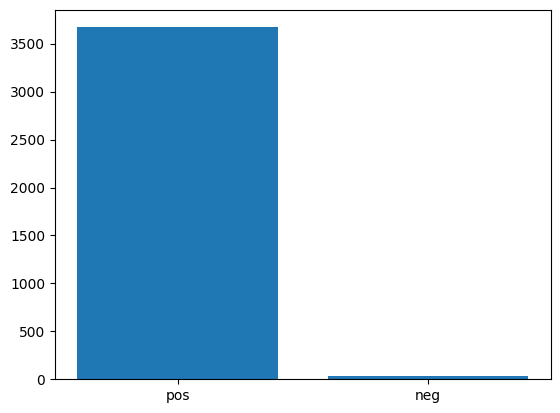

In [ ]:
classify_sentiment(filtered_df, 'polarity_score')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


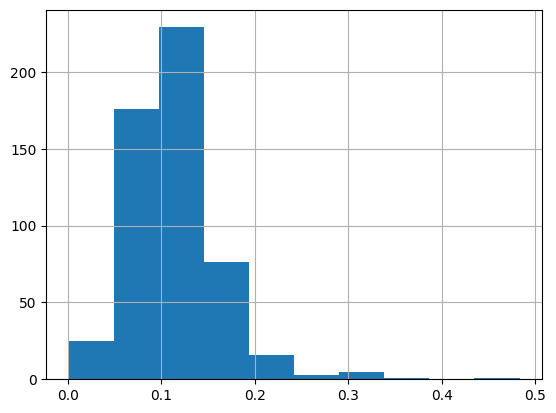

In [ ]:
# repeat with nato

calculate_polarity(filtered_nato, 'stopwords_removed')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Unnamed: 0                date  \
5              5 2000-01-15 00:00:00   
9              9 2000-01-23 00:00:00   
16            16 2000-02-04 00:00:00   
37            37 2000-03-05 14:26:00   
84            84 2000-06-02 00:00:00   
...          ...                 ...   
9290        9290 2022-11-22 16:10:00   
9312        9312 2022-12-09 11:00:00   
9323        9323 2022-12-19 21:20:00   
9329        9329 2022-12-21 16:00:00   
9332        9332 2022-12-22 19:30:00   

                                                                                    transcript_unfiltered  \
5     Sergei Dorenko: Mr. Putin, how do you like your new office, new chair, and your new position? Ar...   
9     Nikolai Svanidze: The most burning topic today is the situation in the State Duma. We have alrea...   
16    Vladimir Putin: Good morning.  We have many important issues on our agenda, and these include th...   
37    David Frost: In his first television interview with a Western or indeed a foreign journalist sin...   
84    On the Presidency Question: Mr President, before you took office you were known mainly to your f...   
...                                                                                                   ...   
9290  The agenda includes the status and prospects of the Russia-Cuba strategic partnership in the pol...   
9312  President of Russia Vladimir Putin: Colleagues, I am delighted to welcome defence ministers of t...   
9323  President of Russia Vladimir Putin: Mr President, ladies and gentlemen, To begin with, I would l...   
9329  Before the meeting, the President visited the exhibition of modern and future samples of equipme...   
9332  President of Russia Vladimir Putin: Please. Yulia Bubnova: Good afternoon. TASS Agency, Yulia Bu...   

                                    place  \
5                                     NaN   
9                                     NaN   
16                                 Moscow   
37    Courtesy "BBC Breakfast with Frost"   
84                                    NaN   
...                                   ...   
9290                  The Kremlin, Moscow   
9312                                  NaN   
9323                                Minsk   
9329                               Moscow   
9332                  The Kremlin, Moscow   

                                                                                        title  \
5                                                                  Interview with ORT Channel   
9                                                           Interview with the RTR TV Channel   
16                                              Opening Address to a Security Council Meeting   
37                                                    Interview to “BBC Breakfast with Frost”   
84                     From the Transcript of an Interview with the American NBC News Channel   
...                                                                                       ...   
9290                                Meeting with President of Cuba Miguel Diaz-Canel Bermudez   
9312  Video address to the participants of the joint meeting of SCO and CIS defence ministers   
9323                                       News conference following Russian-Belarusian talks   
9329                                                        Meeting of Defence Ministry Board   
9332                                       Vladimir Putin answered questions from journalists   

                                                                                              no_contract  \
5     ['Sergei', 'Dorenko:', 'Mr.', 'Putin,', 'how', 'do', 'you', 'like', 'your', 'new', 'office,', 'n...   
9     ['Nikolai', 'Svanidze:', 'The', 'most', 'burning', 'topic', 'today', 'is', 'the', 'situation', '...   
16    ['Vladimir', 'Putin:', 'Good', 'morning.', 'We', 'have', 'many', 'important', 'issues', 'on', 'o...   
37    ['David', 'Frost:', 'In', 'his', 'first', 'television', 'interview',

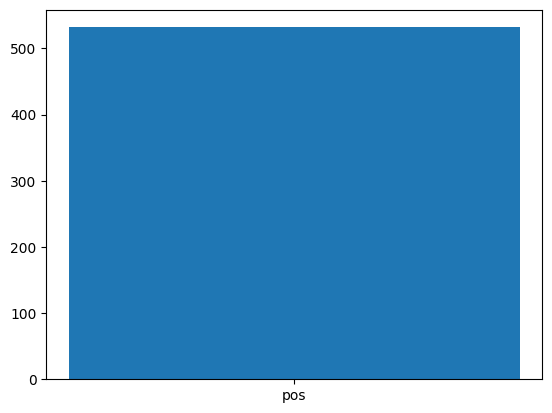

In [ ]:
classify_sentiment(filtered_nato, 'polarity_score')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


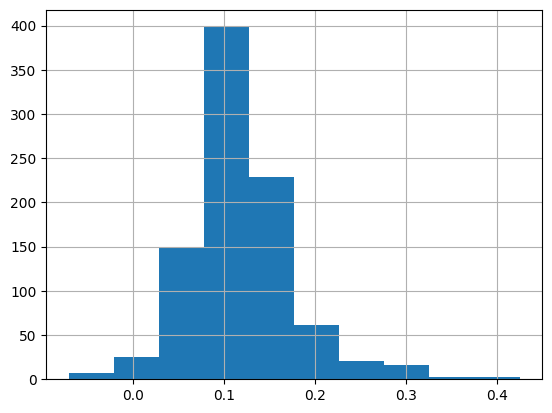

In [ ]:
# repeat with ukraine

calculate_polarity(filtered_ukraine, 'stopwords_removed')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Unnamed: 0                date  \
35            35 2000-03-03 14:16:00   
58            58 2000-04-14 01:00:00   
65            65 2000-04-21 00:00:00   
97            97 2000-06-19 00:00:00   
181          181 2000-12-01 00:00:00   
...          ...                 ...   
9323        9323 2022-12-19 21:20:00   
9326        9326 2022-12-20 21:10:00   
9329        9329 2022-12-21 16:00:00   
9332        9332 2022-12-22 19:30:00   
9339        9339 2022-12-31 23:55:00   

                                                                                    transcript_unfiltered  \
35    Vladimir Putin: Good afternoon.  In recent years the fuel and energy complex has been a factor o...   
58    Vladimir Putin: I would now like to deal very briefly with remarks which I think cannot be left ...   
65    Question: Could you tell us about the Security Council’s decisions on the first issue, the Caspi...   
97    Question: The Kazakhstan delegation and the President of Kazakhstan have completed their first o...   
181   Vladimir Putin: Dear friends,  First of all, I would like to thank our Belarusian colleagues for...   
...                                                                                                   ...   
9323  President of Russia Vladimir Putin: Mr President, ladies and gentlemen, To begin with, I would l...   
9326  President of Russia Vladimir Putin: Mr Pasechnik, it is no secret that the situation in the Luga...   
9329  Before the meeting, the President visited the exhibition of modern and future samples of equipme...   
9332  President of Russia Vladimir Putin: Please. Yulia Bubnova: Good afternoon. TASS Agency, Yulia Bu...   
9339  President of Russia Vladimir Putin: Citizens of Russia, friends, The year 2022 is drawing to a c...   

                       place  \
35                    Surgut   
58    The State Duma, Moscow   
65       The Kremlin, Moscow   
97                    Moscow   
181                    Minsk   
...                      ...   
9323                   Minsk   
9326     The Kremlin, Moscow   
9329                  Moscow   
9332     The Kremlin, Moscow   
9339                     NaN   

                                                                                                    title  \
35      Excerpts from Address to a Nationwide Conference on the Development of the Fuel and Energy Sector   
58    Speech at a State Duma Meeting to Consider the Ratification of the Treaty Between Russia and the...   
65                                                     News Conference Following Security Council Session   
97                                               News Conference Following Russia-Kazakhstan Negotiations   
181   Opening Remarks and Answers to Questions at a Press Conference Following a Meeting of the CIS He...   
...                                                                                                   ...   
9323                                                   News conference following Russian-Belarusian talks   
9326                               Meeting with Acting Head of Lugansk People’s Republic Leonid Pasechnik   
9329                                                                    Meeting of Defence Ministry Board   
9332                                                   Vladimir Putin answered questions from journalists   
9339                                                                       New Year Address to the Nation   

                                                                                              no_contract  \
35    ['Vladimir', 'Putin:', 'Good', 'afternoon.', 'In', 'recent', 'years', 'the', 'fuel', 'and', 'ene...   
58    ['Vladimir', 'Putin:', 'I', 'would', 'now', 'like', 'to', 'deal', 'very', 'briefly', 'with', 're...   
65    ['Question:', 'Could', 'you', 'tell', 'us', 'about', 'the', 'Security', 'Council’s', 'decisions'...   
97    ['Question:', 'The', 'Kazakhstan', 'delegation', 'and', 'the', 'President', 'of'

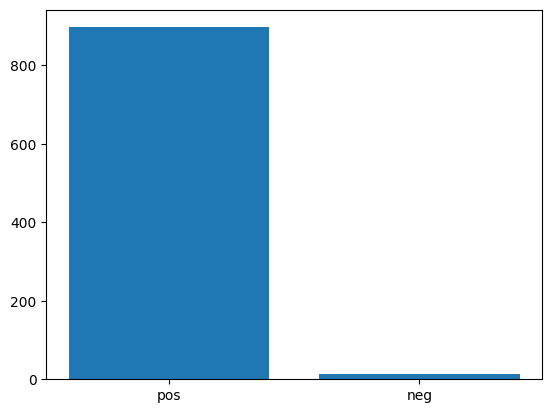

In [ ]:
classify_sentiment(filtered_ukraine, 'polarity_score')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


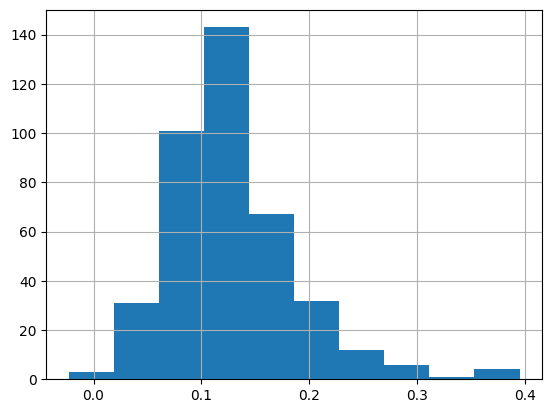

In [ ]:
# repeat with crimea

calculate_polarity(filtered_crimea, 'stopwords_removed')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Unnamed: 0                date  \
305          305 2001-07-29 00:00:00   
360          360 2001-11-07 00:02:00   
576          576 2003-01-28 00:02:00   
652          652 2003-05-02 00:00:00   
654          654 2003-05-04 00:01:00   
...          ...                 ...   
9319        9319 2022-12-15 17:20:00   
9327        9327 2022-12-20 22:30:00   
9329        9329 2022-12-21 16:00:00   
9339        9339 2022-12-31 23:55:00   
9342        9342 2023-01-06 13:00:00   

                                                                                    transcript_unfiltered  \
305   Vladimir Putin: Good afternoon, Allow me to congratulate you on Russian Navy Day. Joint Navy Day...   
360   Question: Mr President, you were in your office and you saw the attack on the World Trade Center...   
576   Vladimir Putin: I would like to thank the President, the Rector and all of you for the opportuni...   
652   Leonid Kuchma: Good afternoon. I am pleased to have the opportunity to meet with President Putin...   
654   Leonid Kuchma: Speaking for the Ukrainian side, I would like to repeat myself. I am very glad th...   
...                                                                                                   ...   
9319  President of Russia Vladimir Putin: Good afternoon, colleagues,  As always at the end of the yea...   
9327  President of Russia Vladimir Putin: Mr Pushilin, I have just spoken to your colleague from the L...   
9329  Before the meeting, the President visited the exhibition of modern and future samples of equipme...   
9339  President of Russia Vladimir Putin: Citizens of Russia, friends, The year 2022 is drawing to a c...   
9342  President of Russia Vladimir Putin: Good afternoon. Promsvyazbank CEO Pyotr Fradkov     Fradkov ...   

                             place  \
305                     Sevastopol   
360                            NaN   
576                           Kiev   
652                  Yalta, Crimea   
654                  Yalta, Crimea   
...                            ...   
9319  Novo-Ogaryovo, Moscow Region   
9327           The Kremlin, Moscow   
9329                        Moscow   
9339                           NaN   
9342           The Kremlin, Moscow   

                                                                                                    title  \
305                            Speech aboard the Guards guided-missile cruiser Moskva on Russian Navy Day   
360                                                  Interview with the American Broadcasting Company ABC   
576   Opening Remarks and Answers to Questions at a Meeting with the Teachers and Students at Taras Sh...   
652   Excerpts from a Transcript of a Joint Press Conference with Ukrainian President Leonid Kuchma af...   
654   Joint Press Conference with Ukrainian President Leonid Kuchma after the Second Round of Russian-...   
...                                                                                                   ...   
9319                                   Meeting of Council for Strategic Development and National Projects   
9327                                 Meeting with Acting Head of Donetsk People’s Republic Denis Pushilin   
9329                                                                    Meeting of Defence Ministry Board   
9339                                                                       New Year Address to the Nation   
9342                                                         Meeting with Promsvyazbank CEO Pyotr Fradkov   

                                                                                              no_contract  \
305   ['Vladimir', 'Putin:', 'Good', 'afternoon,', 'Allow', 'me', 'to', 'congratulate', 'you', 'on', '...   
360   ['Question:', 'Mr', 'President,', 'you', 'were', 'in', 'your', 'office', 'and', 'you', 'saw', 't...   
576   ['Vladimir', 'Putin:', 'I', 'would', 'like', 'to', 'thank', 'the', 'President,', 'the', 'Rector'...   
652   ['Leonid

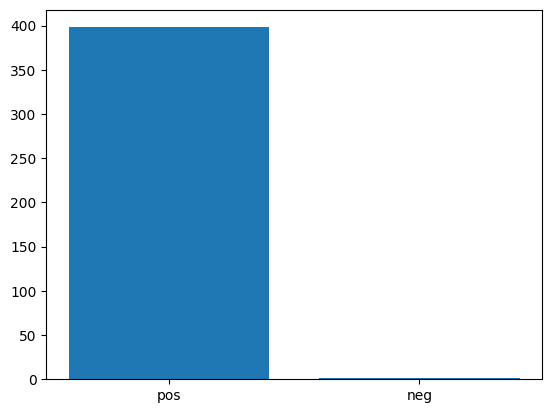

In [ ]:
classify_sentiment(filtered_crimea, 'polarity_score')

### VADER Sentiment Analysis

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
def get_vader_score(sent):
    # Polarity score returns dictionary
    ss = sid.polarity_scores(sent)
    #return ss
    return np.argmax(list(ss.values())[:-1])

def create_vader_polarity_column(df, text_column):
    df['vader_polarity'] = df[text_column].map(get_vader_score).replace({0: 'neg', 1: 'neu', 2: 'pos'})

    plt.bar(df['vader_polarity'].value_counts().index, df['vader_polarity'].value_counts())
    plt.show()

    return df



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


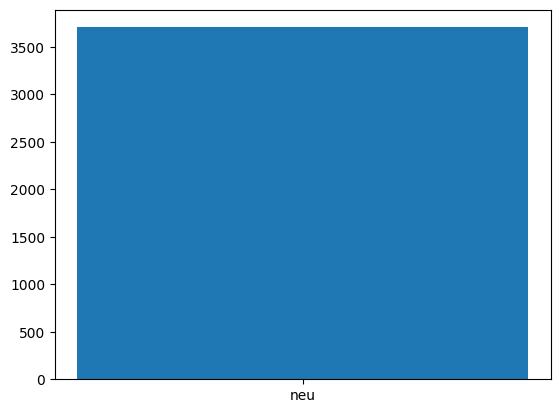

Unnamed: 0                date  \
1              1 1999-12-31 00:02:00   
3              3 2000-01-04 00:00:00   
5              5 2000-01-15 00:00:00   
9              9 2000-01-23 00:00:00   
10            10 2000-01-24 00:00:00   
...          ...                 ...   
9341        9341 2023-01-04 13:40:00   
9342        9342 2023-01-06 13:00:00   
9345        9345 2023-01-11 15:50:00   
9346        9346 2023-01-12 00:00:00   
9348        9348 2023-01-13 14:35:00   

                                                                                    transcript_unfiltered  \
1     Vladimir Putin: Good afternoon, distinguished colleagues. This will be a short meeting. I am ask...   
3     Question: Mr Putin, the sudden resignation of Mr Yeltsin has prompted many questions in this cou...   
5     Sergei Dorenko: Mr. Putin, how do you like your new office, new chair, and your new position? Ar...   
9     Nikolai Svanidze: The most burning topic today is the situation in the State Duma. We have alrea...   
10    Vladimir Putin: Esteemed Mr Lebedev,  Ladies and Gentlemen: You have gathered here to sum up the...   
...                                                                                                   ...   
9341  The frigate Admiral Flota Sovetskogo Soyuza Gorshkov is a modern multi-purpose ship with guided ...   
9342  President of Russia Vladimir Putin: Good afternoon. Promsvyazbank CEO Pyotr Fradkov     Fradkov ...   
9345  The meeting was attended by Prime Minister Mikhail Mishustin     Mishustin MikhailPrime Minister...   
9346  President of Russia Vladimir Putin: Comrade officers, veterans, Congratulations on your professi...   
9348  Pavel Zarubin: Bashkortostan is my homeland. I am from this republic. President of Russia Vladim...   

                             place  \
1              The Kremlin, Moscow   
3                           Moscow   
5                              NaN   
9                              NaN   
10                          Moscow   
...                            ...   
9341  Novo-Ogaryovo, Moscow Region   
9342           The Kremlin, Moscow   
9345  Novo-Ogaryovo, Moscow Region   
9346                           NaN   
9348                           Ufa   

                                                                      title  \
1            Address at an expanded meeting of the Russian Security Council   
3                                         Interview with the ORT TV Channel   
5                                                Interview with ORT Channel   
9                                         Interview with the RTR TV Channel   
10    Speech at a conference of the heads of republican and regional courts   
...                                                                     ...   
9341                           Frigate Admiral Gorshkov started combat duty   
9342                           Meeting with Promsvyazbank CEO Pyotr Fradkov   
9345                                        Meeting with Government members   
9346                     Congratulations on Prosecutor's Office Workers Day   
9348                                         Comment for Rossiya TV channel   

                                                                                              no_contract  \
1     ['Vladimir', 'Putin:', 'Good', 'afternoon,', 'distinguished', 'colleagues.', 'This', 'will', 'be...   
3     ['Question:', 'Mr', 'Putin,', 'the', 'sudden', 'resignation', 'of', 'Mr', 'Yeltsin', 'has', 'pro...   
5     ['Sergei', 'Dorenko:', 'Mr.', 'Putin,', 'how', 'do', 'you', 'like', 'your', 'new', 'office,', 'n...   
9     ['Nikolai', 'Svanidze:', 'The', 'most', 'burning', 'topic', 'today', 'is', 'the', 'situation', '...   
10    ['Vladimir', 'Putin:', 'Esteemed', 'Mr', 'Lebedev,', 'Ladies', 'and', 'Gentlemen:', 'You', 'have...   
...                                                                                                   ...   
9341  ['The', 'frigate', 'Admiral', 'Flota', 'S

In [ ]:
create_vader_polarity_column(filtered_df, 'stopwords_removed')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


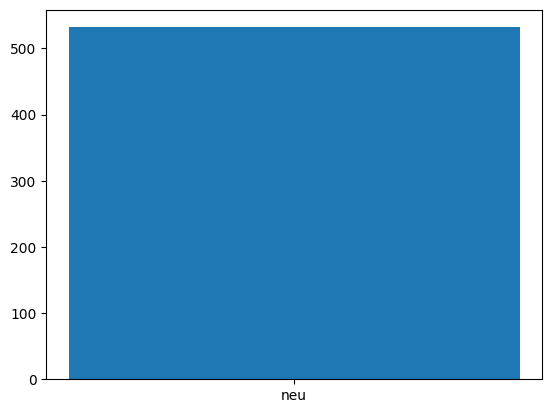

Unnamed: 0                date  \
5              5 2000-01-15 00:00:00   
9              9 2000-01-23 00:00:00   
16            16 2000-02-04 00:00:00   
37            37 2000-03-05 14:26:00   
84            84 2000-06-02 00:00:00   
...          ...                 ...   
9290        9290 2022-11-22 16:10:00   
9312        9312 2022-12-09 11:00:00   
9323        9323 2022-12-19 21:20:00   
9329        9329 2022-12-21 16:00:00   
9332        9332 2022-12-22 19:30:00   

                                                                                    transcript_unfiltered  \
5     Sergei Dorenko: Mr. Putin, how do you like your new office, new chair, and your new position? Ar...   
9     Nikolai Svanidze: The most burning topic today is the situation in the State Duma. We have alrea...   
16    Vladimir Putin: Good morning.  We have many important issues on our agenda, and these include th...   
37    David Frost: In his first television interview with a Western or indeed a foreign journalist sin...   
84    On the Presidency Question: Mr President, before you took office you were known mainly to your f...   
...                                                                                                   ...   
9290  The agenda includes the status and prospects of the Russia-Cuba strategic partnership in the pol...   
9312  President of Russia Vladimir Putin: Colleagues, I am delighted to welcome defence ministers of t...   
9323  President of Russia Vladimir Putin: Mr President, ladies and gentlemen, To begin with, I would l...   
9329  Before the meeting, the President visited the exhibition of modern and future samples of equipme...   
9332  President of Russia Vladimir Putin: Please. Yulia Bubnova: Good afternoon. TASS Agency, Yulia Bu...   

                                    place  \
5                                     NaN   
9                                     NaN   
16                                 Moscow   
37    Courtesy "BBC Breakfast with Frost"   
84                                    NaN   
...                                   ...   
9290                  The Kremlin, Moscow   
9312                                  NaN   
9323                                Minsk   
9329                               Moscow   
9332                  The Kremlin, Moscow   

                                                                                        title  \
5                                                                  Interview with ORT Channel   
9                                                           Interview with the RTR TV Channel   
16                                              Opening Address to a Security Council Meeting   
37                                                    Interview to “BBC Breakfast with Frost”   
84                     From the Transcript of an Interview with the American NBC News Channel   
...                                                                                       ...   
9290                                Meeting with President of Cuba Miguel Diaz-Canel Bermudez   
9312  Video address to the participants of the joint meeting of SCO and CIS defence ministers   
9323                                       News conference following Russian-Belarusian talks   
9329                                                        Meeting of Defence Ministry Board   
9332                                       Vladimir Putin answered questions from journalists   

                                                                                              no_contract  \
5     ['Sergei', 'Dorenko:', 'Mr.', 'Putin,', 'how', 'do', 'you', 'like', 'your', 'new', 'office,', 'n...   
9     ['Nikolai', 'Svanidze:', 'The', 'most', 'burning', 'topic', 'today', 'is', 'the', 'situation', '...   
16    ['Vladimir', 'Putin:', 'Good', 'morning.', 'We', 'have', 'many', 'important', 'issues', 'on', 'o...   
37    ['David', 'Frost:', 'In', 'his', 'first', 'television', 'interview',

In [ ]:
# repeat for nato

create_vader_polarity_column(filtered_nato, 'stopwords_removed')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


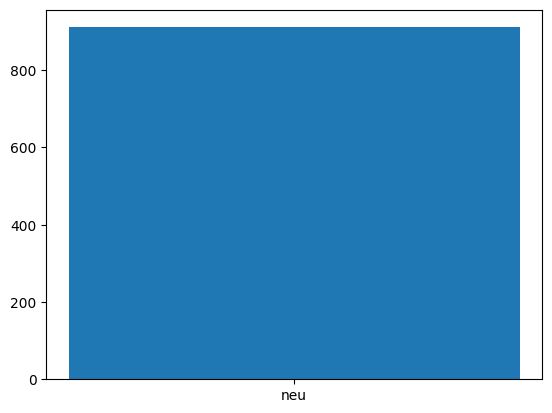

Unnamed: 0                date  \
35            35 2000-03-03 14:16:00   
58            58 2000-04-14 01:00:00   
65            65 2000-04-21 00:00:00   
97            97 2000-06-19 00:00:00   
181          181 2000-12-01 00:00:00   
...          ...                 ...   
9323        9323 2022-12-19 21:20:00   
9326        9326 2022-12-20 21:10:00   
9329        9329 2022-12-21 16:00:00   
9332        9332 2022-12-22 19:30:00   
9339        9339 2022-12-31 23:55:00   

                                                                                    transcript_unfiltered  \
35    Vladimir Putin: Good afternoon.  In recent years the fuel and energy complex has been a factor o...   
58    Vladimir Putin: I would now like to deal very briefly with remarks which I think cannot be left ...   
65    Question: Could you tell us about the Security Council’s decisions on the first issue, the Caspi...   
97    Question: The Kazakhstan delegation and the President of Kazakhstan have completed their first o...   
181   Vladimir Putin: Dear friends,  First of all, I would like to thank our Belarusian colleagues for...   
...                                                                                                   ...   
9323  President of Russia Vladimir Putin: Mr President, ladies and gentlemen, To begin with, I would l...   
9326  President of Russia Vladimir Putin: Mr Pasechnik, it is no secret that the situation in the Luga...   
9329  Before the meeting, the President visited the exhibition of modern and future samples of equipme...   
9332  President of Russia Vladimir Putin: Please. Yulia Bubnova: Good afternoon. TASS Agency, Yulia Bu...   
9339  President of Russia Vladimir Putin: Citizens of Russia, friends, The year 2022 is drawing to a c...   

                       place  \
35                    Surgut   
58    The State Duma, Moscow   
65       The Kremlin, Moscow   
97                    Moscow   
181                    Minsk   
...                      ...   
9323                   Minsk   
9326     The Kremlin, Moscow   
9329                  Moscow   
9332     The Kremlin, Moscow   
9339                     NaN   

                                                                                                    title  \
35      Excerpts from Address to a Nationwide Conference on the Development of the Fuel and Energy Sector   
58    Speech at a State Duma Meeting to Consider the Ratification of the Treaty Between Russia and the...   
65                                                     News Conference Following Security Council Session   
97                                               News Conference Following Russia-Kazakhstan Negotiations   
181   Opening Remarks and Answers to Questions at a Press Conference Following a Meeting of the CIS He...   
...                                                                                                   ...   
9323                                                   News conference following Russian-Belarusian talks   
9326                               Meeting with Acting Head of Lugansk People’s Republic Leonid Pasechnik   
9329                                                                    Meeting of Defence Ministry Board   
9332                                                   Vladimir Putin answered questions from journalists   
9339                                                                       New Year Address to the Nation   

                                                                                              no_contract  \
35    ['Vladimir', 'Putin:', 'Good', 'afternoon.', 'In', 'recent', 'years', 'the', 'fuel', 'and', 'ene...   
58    ['Vladimir', 'Putin:', 'I', 'would', 'now', 'like', 'to', 'deal', 'very', 'briefly', 'with', 're...   
65    ['Question:', 'Could', 'you', 'tell', 'us', 'about', 'the', 'Security', 'Council’s', 'decisions'...   
97    ['Question:', 'The', 'Kazakhstan', 'delegation', 'and', 'the', 'President', 'of'

In [ ]:
# repeat for ukraine

create_vader_polarity_column(filtered_ukraine, 'stopwords_removed')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


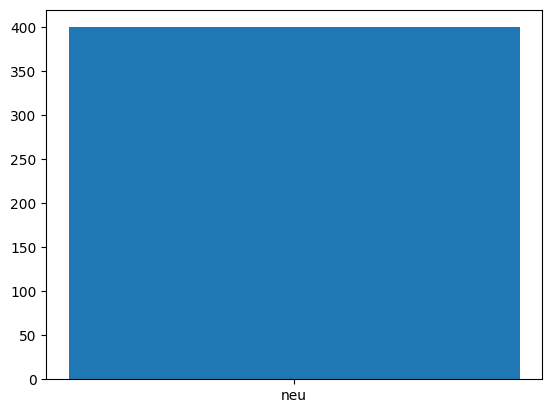

Unnamed: 0                date  \
305          305 2001-07-29 00:00:00   
360          360 2001-11-07 00:02:00   
576          576 2003-01-28 00:02:00   
652          652 2003-05-02 00:00:00   
654          654 2003-05-04 00:01:00   
...          ...                 ...   
9319        9319 2022-12-15 17:20:00   
9327        9327 2022-12-20 22:30:00   
9329        9329 2022-12-21 16:00:00   
9339        9339 2022-12-31 23:55:00   
9342        9342 2023-01-06 13:00:00   

                                                                                    transcript_unfiltered  \
305   Vladimir Putin: Good afternoon, Allow me to congratulate you on Russian Navy Day. Joint Navy Day...   
360   Question: Mr President, you were in your office and you saw the attack on the World Trade Center...   
576   Vladimir Putin: I would like to thank the President, the Rector and all of you for the opportuni...   
652   Leonid Kuchma: Good afternoon. I am pleased to have the opportunity to meet with President Putin...   
654   Leonid Kuchma: Speaking for the Ukrainian side, I would like to repeat myself. I am very glad th...   
...                                                                                                   ...   
9319  President of Russia Vladimir Putin: Good afternoon, colleagues,  As always at the end of the yea...   
9327  President of Russia Vladimir Putin: Mr Pushilin, I have just spoken to your colleague from the L...   
9329  Before the meeting, the President visited the exhibition of modern and future samples of equipme...   
9339  President of Russia Vladimir Putin: Citizens of Russia, friends, The year 2022 is drawing to a c...   
9342  President of Russia Vladimir Putin: Good afternoon. Promsvyazbank CEO Pyotr Fradkov     Fradkov ...   

                             place  \
305                     Sevastopol   
360                            NaN   
576                           Kiev   
652                  Yalta, Crimea   
654                  Yalta, Crimea   
...                            ...   
9319  Novo-Ogaryovo, Moscow Region   
9327           The Kremlin, Moscow   
9329                        Moscow   
9339                           NaN   
9342           The Kremlin, Moscow   

                                                                                                    title  \
305                            Speech aboard the Guards guided-missile cruiser Moskva on Russian Navy Day   
360                                                  Interview with the American Broadcasting Company ABC   
576   Opening Remarks and Answers to Questions at a Meeting with the Teachers and Students at Taras Sh...   
652   Excerpts from a Transcript of a Joint Press Conference with Ukrainian President Leonid Kuchma af...   
654   Joint Press Conference with Ukrainian President Leonid Kuchma after the Second Round of Russian-...   
...                                                                                                   ...   
9319                                   Meeting of Council for Strategic Development and National Projects   
9327                                 Meeting with Acting Head of Donetsk People’s Republic Denis Pushilin   
9329                                                                    Meeting of Defence Ministry Board   
9339                                                                       New Year Address to the Nation   
9342                                                         Meeting with Promsvyazbank CEO Pyotr Fradkov   

                                                                                              no_contract  \
305   ['Vladimir', 'Putin:', 'Good', 'afternoon,', 'Allow', 'me', 'to', 'congratulate', 'you', 'on', '...   
360   ['Question:', 'Mr', 'President,', 'you', 'were', 'in', 'your', 'office', 'and', 'you', 'saw', 't...   
576   ['Vladimir', 'Putin:', 'I', 'would', 'like', 'to', 'thank', 'the', 'President,', 'the', 'Rector'...   
652   ['Leonid

In [ ]:
# repeat for crimea

create_vader_polarity_column(filtered_crimea, 'stopwords_removed')

VADER found all the transcripts neutral.

### Named Entity Recognition

In [ ]:
!python -m spacy download en_core_web_sm

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2023-11-10 21:50:00.093869: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-10 21:50:00.094007: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-10 21:50:00.094242: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-10 21:50:00.148959: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-10 21:50:02.995985: W tensorflow/compiler/

In [ ]:
import spacy

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/dtypes.py:35: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  from tensorflow.tsl.python.lib.core import pywrap_ml_dtypes


In [ ]:
nlp = spacy.load("en_core_web_sm")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import spacy
from collections import  Counter
import seaborn as sns

def plot_named_entity_barchart(text):
    nlp = spacy.load("en_core_web_sm")

    def _get_ner(text):
        doc=nlp(text)
        return [X.label_ for X in doc.ents]

    ent=text.apply(lambda x : _get_ner(x))
    ent=[x for sub in ent for x in sub]
    counter=Counter(ent)
    count=counter.most_common()

    x,y=map(list,zip(*count))
    sns.barplot(x=y,y=x)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, Exte

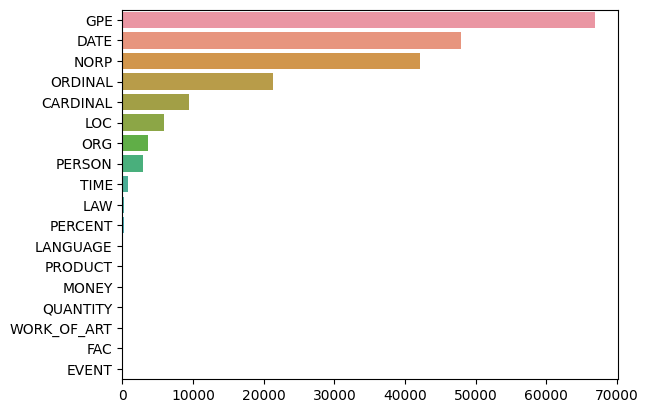

In [ ]:
plot_named_entity_barchart(filtered_df['stopwords_removed'])

PERSON:      People, including fictional.

NORP:        Nationalities or religious or political groups.

FAC:         Buildings, airports, highways, bridges, etc.

ORG:         Companies, agencies, institutions, etc.

GPE:         Countries, cities, states.

LOC:         Non-GPE locations, mountain ranges, bodies of water.

PRODUCT:     Objects, vehicles, foods, etc. (Not services.)

EVENT:       Named hurricanes, battles, wars, sports events, etc.

WORK_OF_ART: Titles of books, songs, etc.

LAW:         Named documents made into laws.

LANGUAGE:    Any named language.

DATE:        Absolute or relative dates or periods.

TIME:        Times smaller than a day.

PERCENT:     Percentage, including ”%“.

MONEY:       Monetary values, including unit.

QUANTITY:    Measurements, as of weight or distance.

ORDINAL:     “first”, “second”, etc.

CARDINAL:    Numerals that do not fall under another type.

### Save Dataframe with New Columns


In [ ]:
filtered_df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Unnamed: 0                date  \
1            1 1999-12-31 00:02:00   
3            3 2000-01-04 00:00:00   
5            5 2000-01-15 00:00:00   
9            9 2000-01-23 00:00:00   
10          10 2000-01-24 00:00:00   

                                                                                  transcript_unfiltered  \
1   Vladimir Putin: Good afternoon, distinguished colleagues. This will be a short meeting. I am ask...   
3   Question: Mr Putin, the sudden resignation of Mr Yeltsin has prompted many questions in this cou...   
5   Sergei Dorenko: Mr. Putin, how do you like your new office, new chair, and your new position? Ar...   
9   Nikolai Svanidze: The most burning topic today is the situation in the State Duma. We have alrea...   
10  Vladimir Putin: Esteemed Mr Lebedev,  Ladies and Gentlemen: You have gathered here to sum up the...   

                  place  \
1   The Kremlin, Moscow   
3                Moscow   
5                   NaN   
9                   NaN   
10               Moscow   

                                                                    title  \
1          Address at an expanded meeting of the Russian Security Council   
3                                       Interview with the ORT TV Channel   
5                                              Interview with ORT Channel   
9                                       Interview with the RTR TV Channel   
10  Speech at a conference of the heads of republican and regional courts   

                                                                                            no_contract  \
1   ['Vladimir', 'Putin:', 'Good', 'afternoon,', 'distinguished', 'colleagues.', 'This', 'will', 'be...   
3   ['Question:', 'Mr', 'Putin,', 'the', 'sudden', 'resignation', 'of', 'Mr', 'Yeltsin', 'has', 'pro...   
5   ['Sergei', 'Dorenko:', 'Mr.', 'Putin,', 'how', 'do', 'you', 'like', 'your', 'new', 'office,', 'n...   
9   ['Nikolai', 'Svanidze:', 'The', 'most', 'burning', 'topic', 'today', 'is', 'the', 'situation', '...   
10  ['Vladimir', 'Putin:', 'Esteemed', 'Mr', 'Lebedev,', 'Ladies', 'and', 'Gentlemen:', 'You', 'have...   

                                                                              transcript_unfiltered_str  \
1   Vladimir Putin: Good afternoon, distinguished colleagues. This will be a short meeting. I am ask...   
3   Question: Mr Putin, the sudden resignation of Mr Yeltsin has prompted many questions in this cou...   
5   Sergei Dorenko: Mr. Putin, how do you like your new office, new chair, and your new position? Ar...   
9   Nikolai Svanidze: The most burning topic today is the situation in the State Duma. We have alrea...   
10  Vladimir Putin: Esteemed Mr Lebedev, Ladies and Gentlemen: You have gathered here to sum up the ...   

                                                                             transcripts_word_tokenized  \
1   ['Vladimir', 'Putin', ':', 'Good', 'afternoon', ',', 'distinguished', 'colleagues', '.', 'This',...   
3   ['Question', ':', 'Mr', 'Putin', ',', 'the', 'sudden', 'resignation', 'of', 'Mr', 'Yeltsin', 'ha...   
5   ['Sergei', 'Dorenko', ':', 'Mr.', 'Putin', ',', 'how', 'do', 'you', 'like', 'your', 'new', 'offi...   
9   ['Nikolai', 'Svanidze', ':', 'The', 'most', 'burning', 'topic', 'today', 'is', 'the', 'situation...   
10  ['Vladimir', 'Putin', ':', 'Esteemed', 'Mr', 'Lebedev', ',', 'Ladies', 'and', 'Gentlemen', ':', ...   

                                                                         transcripts_sentence_tokenized  \
1   ['Vladimir Putin: Good afternoon, distinguished colleagues.', 'This will be a short meeting.', '...   
3   ['Question: Mr Putin, the sudden resignation of Mr Yeltsin has prompted many questions in this c...   
5   ['Sergei Dorenko: Mr. Putin, how do you like your new office, new chair, and your new position?'...   
9   ['Nikolai Svanidze: The most burning topic today is the situation in the State Duma.', 'We have ...   
10  ['Vladimir Putin: Esteemed Mr Lebedev,

In [ ]:
filtered_nato.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Unnamed: 0                date  \
5            5 2000-01-15 00:00:00   
9            9 2000-01-23 00:00:00   
16          16 2000-02-04 00:00:00   
37          37 2000-03-05 14:26:00   
84          84 2000-06-02 00:00:00   

                                                                                  transcript_unfiltered  \
5   Sergei Dorenko: Mr. Putin, how do you like your new office, new chair, and your new position? Ar...   
9   Nikolai Svanidze: The most burning topic today is the situation in the State Duma. We have alrea...   
16  Vladimir Putin: Good morning.  We have many important issues on our agenda, and these include th...   
37  David Frost: In his first television interview with a Western or indeed a foreign journalist sin...   
84  On the Presidency Question: Mr President, before you took office you were known mainly to your f...   

                                  place  \
5                                   NaN   
9                                   NaN   
16                               Moscow   
37  Courtesy "BBC Breakfast with Frost"   
84                                  NaN   

                                                                     title  \
5                                               Interview with ORT Channel   
9                                        Interview with the RTR TV Channel   
16                           Opening Address to a Security Council Meeting   
37                                 Interview to “BBC Breakfast with Frost”   
84  From the Transcript of an Interview with the American NBC News Channel   

                                                                                            no_contract  \
5   ['Sergei', 'Dorenko:', 'Mr.', 'Putin,', 'how', 'do', 'you', 'like', 'your', 'new', 'office,', 'n...   
9   ['Nikolai', 'Svanidze:', 'The', 'most', 'burning', 'topic', 'today', 'is', 'the', 'situation', '...   
16  ['Vladimir', 'Putin:', 'Good', 'morning.', 'We', 'have', 'many', 'important', 'issues', 'on', 'o...   
37  ['David', 'Frost:', 'In', 'his', 'first', 'television', 'interview', 'with', 'a', 'Western', 'or...   
84  ['On', 'the', 'Presidency', 'Question:', 'Mr', 'President,', 'before', 'you', 'took', 'office', ...   

                                                                              transcript_unfiltered_str  \
5   Sergei Dorenko: Mr. Putin, how do you like your new office, new chair, and your new position? Ar...   
9   Nikolai Svanidze: The most burning topic today is the situation in the State Duma. We have alrea...   
16  Vladimir Putin: Good morning. We have many important issues on our agenda, and these include the...   
37  David Frost: In his first television interview with a Western or indeed a foreign journalist sin...   
84  On the Presidency Question: Mr President, before you took office you were known mainly to your f...   

                                                                             transcripts_word_tokenized  \
5   ['Sergei', 'Dorenko', ':', 'Mr.', 'Putin', ',', 'how', 'do', 'you', 'like', 'your', 'new', 'offi...   
9   ['Nikolai', 'Svanidze', ':', 'The', 'most', 'burning', 'topic', 'today', 'is', 'the', 'situation...   
16  ['Vladimir', 'Putin', ':', 'Good', 'morning', '.', 'We', 'have', 'many', 'important', 'issues', ...   
37  ['David', 'Frost', ':', 'In', 'his', 'first', 'television', 'interview', 'with', 'a', 'Western',...   
84  ['On', 'the', 'Presidency', 'Question', ':', 'Mr', 'President', ',', 'before', 'you', 'took', 'o...   

                                                                         transcripts_sentence_tokenized  \
5   ['Sergei Dorenko: Mr. Putin, how do you like your new office, new chair, and your new position?'...   
9   ['Nikolai Svanidze: The most burning topic today is the situation in the State Duma.', 'We have ...   
16  ['Vladimir Putin: Good morning.', 'We have many important issues on our agenda, and these includ...   
37  ['David Frost: In his first television inte

In [ ]:
filtered_ukraine.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Unnamed: 0                date  \
35           35 2000-03-03 14:16:00   
58           58 2000-04-14 01:00:00   
65           65 2000-04-21 00:00:00   
97           97 2000-06-19 00:00:00   
181         181 2000-12-01 00:00:00   

                                                                                   transcript_unfiltered  \
35   Vladimir Putin: Good afternoon.  In recent years the fuel and energy complex has been a factor o...   
58   Vladimir Putin: I would now like to deal very briefly with remarks which I think cannot be left ...   
65   Question: Could you tell us about the Security Council’s decisions on the first issue, the Caspi...   
97   Question: The Kazakhstan delegation and the President of Kazakhstan have completed their first o...   
181  Vladimir Putin: Dear friends,  First of all, I would like to thank our Belarusian colleagues for...   

                      place  \
35                   Surgut   
58   The State Duma, Moscow   
65      The Kremlin, Moscow   
97                   Moscow   
181                   Minsk   

                                                                                                   title  \
35     Excerpts from Address to a Nationwide Conference on the Development of the Fuel and Energy Sector   
58   Speech at a State Duma Meeting to Consider the Ratification of the Treaty Between Russia and the...   
65                                                    News Conference Following Security Council Session   
97                                              News Conference Following Russia-Kazakhstan Negotiations   
181  Opening Remarks and Answers to Questions at a Press Conference Following a Meeting of the CIS He...   

                                                                                             no_contract  \
35   ['Vladimir', 'Putin:', 'Good', 'afternoon.', 'In', 'recent', 'years', 'the', 'fuel', 'and', 'ene...   
58   ['Vladimir', 'Putin:', 'I', 'would', 'now', 'like', 'to', 'deal', 'very', 'briefly', 'with', 're...   
65   ['Question:', 'Could', 'you', 'tell', 'us', 'about', 'the', 'Security', 'Council’s', 'decisions'...   
97   ['Question:', 'The', 'Kazakhstan', 'delegation', 'and', 'the', 'President', 'of', 'Kazakhstan', ...   
181  ['Vladimir', 'Putin:', 'Dear', 'friends,', 'First', 'of', 'all,', 'I', 'would', 'like', 'to', 't...   

                                                                               transcript_unfiltered_str  \
35   Vladimir Putin: Good afternoon. In recent years the fuel and energy complex has been a factor of...   
58   Vladimir Putin: I would now like to deal very briefly with remarks which I think cannot be left ...   
65   Question: Could you tell us about the Security Council’s decisions on the first issue, the Caspi...   
97   Question: The Kazakhstan delegation and the President of Kazakhstan have completed their first o...   
181  Vladimir Putin: Dear friends, First of all, I would like to thank our Belarusian colleagues for ...   

                                                                              transcripts_word_tokenized  \
35   ['Vladimir', 'Putin', ':', 'Good', 'afternoon', '.', 'In', 'recent', 'years', 'the', 'fuel', 'an...   
58   ['Vladimir', 'Putin', ':', 'I', 'would', 'now', 'like', 'to', 'deal', 'very', 'briefly', 'with',...   
65   ['Question', ':', 'Could', 'you', 'tell', 'us', 'about', 'the', 'Security', 'Council', '’', 's',...   
97   ['Question', ':', 'The', 'Kazakhstan', 'delegation', 'and', 'the', 'President', 'of', 'Kazakhsta...   
181  ['Vladimir', 'Putin', ':', 'Dear', 'friends', ',', 'First', 'of', 'all', ',', 'I', 'would', 'lik...   

                                                                          transcripts_sentence_tokenized  \
35   ['Vladimir Putin: Good afternoon.', 'In recent years the fuel and energy complex has been a fact...   
58   ['Vladimir Putin: I would now like to deal very briefly with remarks which I think cannot be lef...   
65   ['Questio

In [ ]:
filtered_crimea.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Unnamed: 0                date  \
305         305 2001-07-29 00:00:00   
360         360 2001-11-07 00:02:00   
576         576 2003-01-28 00:02:00   
652         652 2003-05-02 00:00:00   
654         654 2003-05-04 00:01:00   

                                                                                   transcript_unfiltered  \
305  Vladimir Putin: Good afternoon, Allow me to congratulate you on Russian Navy Day. Joint Navy Day...   
360  Question: Mr President, you were in your office and you saw the attack on the World Trade Center...   
576  Vladimir Putin: I would like to thank the President, the Rector and all of you for the opportuni...   
652  Leonid Kuchma: Good afternoon. I am pleased to have the opportunity to meet with President Putin...   
654  Leonid Kuchma: Speaking for the Ukrainian side, I would like to repeat myself. I am very glad th...   

             place  \
305     Sevastopol   
360            NaN   
576           Kiev   
652  Yalta, Crimea   
654  Yalta, Crimea   

                                                                                                   title  \
305                           Speech aboard the Guards guided-missile cruiser Moskva on Russian Navy Day   
360                                                 Interview with the American Broadcasting Company ABC   
576  Opening Remarks and Answers to Questions at a Meeting with the Teachers and Students at Taras Sh...   
652  Excerpts from a Transcript of a Joint Press Conference with Ukrainian President Leonid Kuchma af...   
654  Joint Press Conference with Ukrainian President Leonid Kuchma after the Second Round of Russian-...   

                                                                                             no_contract  \
305  ['Vladimir', 'Putin:', 'Good', 'afternoon,', 'Allow', 'me', 'to', 'congratulate', 'you', 'on', '...   
360  ['Question:', 'Mr', 'President,', 'you', 'were', 'in', 'your', 'office', 'and', 'you', 'saw', 't...   
576  ['Vladimir', 'Putin:', 'I', 'would', 'like', 'to', 'thank', 'the', 'President,', 'the', 'Rector'...   
652  ['Leonid', 'Kuchma:', 'Good', 'afternoon.', 'I', 'am', 'pleased', 'to', 'have', 'the', 'opportun...   
654  ['Leonid', 'Kuchma:', 'Speaking', 'for', 'the', 'Ukrainian', 'side,', 'I', 'would', 'like', 'to'...   

                                                                               transcript_unfiltered_str  \
305  Vladimir Putin: Good afternoon, Allow me to congratulate you on Russian Navy Day. Joint Navy Day...   
360  Question: Mr President, you were in your office and you saw the attack on the World Trade Center...   
576  Vladimir Putin: I would like to thank the President, the Rector and all of you for the opportuni...   
652  Leonid Kuchma: Good afternoon. I am pleased to have the opportunity to meet with President Putin...   
654  Leonid Kuchma: Speaking for the Ukrainian side, I would like to repeat myself. I am very glad th...   

                                                                              transcripts_word_tokenized  \
305  ['Vladimir', 'Putin', ':', 'Good', 'afternoon', ',', 'Allow', 'me', 'to', 'congratulate', 'you',...   
360  ['Question', ':', 'Mr', 'President', ',', 'you', 'were', 'in', 'your', 'office', 'and', 'you', '...   
576  ['Vladimir', 'Putin', ':', 'I', 'would', 'like', 'to', 'thank', 'the', 'President', ',', 'the', ...   
652  ['Leonid', 'Kuchma', ':', 'Good', 'afternoon', '.', 'I', 'am', 'pleased', 'to', 'have', 'the', '...   
654  ['Leonid', 'Kuchma', ':', 'Speaking', 'for', 'the', 'Ukrainian', 'side', ',', 'I', 'would', 'lik...   

                                                                          transcripts_sentence_tokenized  \
305  ['Vladimir Putin: Good afternoon, Allow me to congratulate you on Russian Navy Day.', 'Joint Nav...   
360  ['Question: Mr President, you were in your office and you saw the attack on the World Trade Cent...   
576  ['Vladimir Putin: I would like to thank the President, the Rect

In [ ]:
filtered_df.to_csv('/content/drive/MyDrive/DATA 495/filtered_df_4sentiment.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
filtered_nato.to_csv('/content/drive/MyDrive/DATA 495/filtered_nato_4sentiment.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
filtered_ukraine.to_csv('/content/drive/MyDrive/DATA 495/filtered_ukraine_4sentiment.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
filtered_crimea.to_csv('/content/drive/MyDrive/DATA 495/filtered_crimea_4sentiment.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
